In [9]:
import os
os.environ['OPENBLAS_NUM_THREADS'] = '1'

%matplotlib inline
from copy import deepcopy as copy
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import numpy as np
from scipy import stats
import scipy.io as sio
import pandas as pd
import pickle
from collections import OrderedDict
from scipy.ndimage.interpolation import shift
from functools import reduce
import time
import re
from scipy.special import comb
import time
import asyncio
from bisect import bisect_left
from matplotlib import cm
import matplotlib.ticker as mtick

from aux import Generic, bin_occurrences, safe_apply_stat, flatten
from disp import set_font_size, get_spaced_colors, graph_weight_matrix
from ntwk import LIFNtwkG
from utils.general import *
from utils.file_io import *

dt = 0.2e-3
BATCH_SIZE = 100

plt.rcParams['font.size'] = 12
plt.rcParams['axes.linewidth'] = 3.0

purple = '#9b358c'
blue = '#25abd0'
red = 'red'

# matplotlib.rcParams['font.sans-serif'] = 'Helvetica'
# matplotlib.rcParams['font.family'] = 'sans-serif'

In [10]:
color_sets = [
    (purple, blue),
    ('#DA70D6', '#5959ff'),
    ('#97178F', '#040299'),
]

In [25]:
def save_fig(fig, path, name):
    full_path = os.path.join(path, name)
    
    if not os.path.exists(path):
        os.makedirs(path)
    else:
        if os.path.isfile(full_path):
            os.remove(full_path)
    fig.savefig(os.path.join(path, name))
    
def get_equally_spaced_colors(n, cmap='autumn'):
    cmap = plt.get_cmap(cmap)
    colors = cmap(np.linspace(0, 1, n))
    return [matplotlib.colors.rgb2hex(rgba) for rgba in colors]

def process_single_activation(exc_raster, n):
    # extract first spikes
    first_spk_times = np.nan * np.ones(n)
    for i in range(exc_raster.shape[1]):
        nrn_idx = int(exc_raster[1, i])
        if np.isnan(first_spk_times[nrn_idx]):
            first_spk_times[nrn_idx] = exc_raster[0, i]
    return first_spk_times

def reinflate_raster(sparse_raster, dims):
    dense_raster = np.zeros(dims).astype(int)
    for i in range(sparse_raster.shape[1]):
        dense_raster[sparse_raster[0, i], sparse_raster[1, i]] = 1
    return dense_raster

def files_needed_from_timepoints(file_names, timepoints):
    file_idxs = (np.array(timepoints) / BATCH_SIZE).astype(int)
    file_idxs_cleaned = []
    for file_idx in file_idxs:
        if file_idx < len(file_names):
            file_idxs_cleaned.append(file_idx)    
    file_idxs = file_idxs_cleaned
    
    rel_file_idxs = []
    tps_grouped = []
    
    last_file_idx = None
    for tp, file_idx in zip(timepoints, file_idxs):
        
        rel_idx = tp % BATCH_SIZE
        
        if file_idx == last_file_idx:
            rel_file_idxs[-1].append(rel_idx)
            tps_grouped[-1].append(tp)
        else:
            rel_file_idxs.append([rel_idx])
            tps_grouped.append([tp])
            last_file_idx = file_idx
    
    return zip(np.arange(len(rel_file_idxs)), np.array(file_names)[np.unique(file_idxs).astype(int)], rel_file_idxs, tps_grouped)

def attempt_load(name, source, dest):
    try:
        dest[name] = source[name]
        return True
    except ValueError as e:
        return False
    
def key_sort_by_numerical_suffix(f_name):
    final_underscore_loc = f_name.rfind('_')
    if final_underscore_loc == -1:
        return 10000
    else:
        return int(f_name[(final_underscore_loc + 1):])
    
def load_exp_data(direc, timepoints, n_exc=1000, new_cell_idx=1000, name_frags=[], reverse=False):
    file_names = []
    for f in sorted(all_files_from_dir(direc), key=key_sort_by_numerical_suffix):
        if not f.startswith('log') and not f.endswith('.zip'):
            file_names.append(f)

    file_names = [f for f in filter_list_by_name_frags(file_names, name_frags)]
    
    file_name_count = range(0, len(file_names))
    if reverse:
        file_name_count = reversed(file_name_count)
        
    files_needed = files_needed_from_timepoints(file_names, timepoints)
    
    l = 0
        
    for i, file, rel_file_idxs, tps in files_needed:
        loaded = sio.loadmat(os.path.join(direc, file))
        
        for j, rel_file_idx in enumerate(rel_file_idxs):
            loaded_rendition_data = loaded['data'][0][rel_file_idx]
            tp = tps[j]

            exc_raster = loaded_rendition_data['exc_raster'][0][0]
            inh_raster = loaded_rendition_data['inh_raster'][0][0]
            
            first_spk_times = process_single_activation(exc_raster.astype(float), n_exc)

            layers_active = []
            layer_weights = []

            rendition_data = {
                'first_spk_times': first_spk_times,

                'w_e_e': loaded_rendition_data['w_e_e'][0],
                'w_e_i': loaded_rendition_data['w_e_i'][0],
                'w_i_e': loaded_rendition_data['w_i_e'][0],

                'exc_raster': exc_raster,
                'inh_raster': inh_raster,
                'freqs': loaded_rendition_data['freqs'][0],
                'spk_bins': loaded_rendition_data['spk_bins'][0],

                'exc_raster_unperturbed': exc_raster,
            }    
            
            attempt_load('gs', loaded_rendition_data, rendition_data)

            surviving_cell_mask = None
            if attempt_load('surviving_cell_mask', loaded_rendition_data, rendition_data):
                surviving_cell_mask = loaded_rendition_data['surviving_cell_mask'][0][0][0].astype(bool)
                rendition_data['surviving_cell_mask'] = surviving_cell_mask

                sorting_order = np.argsort(exc_raster[1, :])
                exc_raster_sorted = exc_raster[:, sorting_order]
                indices = np.arange(len(surviving_cell_mask))[surviving_cell_mask.astype(bool)]

                exc_raster_unperturbed = []
                exc_raster_perturbed = []

                k = 0
                for idx in np.arange(exc_raster_sorted.shape[1]):
                    spike_not_added = True
                    
                    while spike_not_added:
                        if k >= len(indices):
                            exc_raster_perturbed.append(exc_raster_sorted[:, idx].reshape(2, 1))
                            spike_not_added = False
                        elif exc_raster_sorted[1, idx] < indices[k]:
                            exc_raster_perturbed.append(exc_raster_sorted[:, idx].reshape(2, 1))
                            spike_not_added = False
                        elif exc_raster_sorted[1, idx] == indices[k]:
                            exc_raster_unperturbed.append(exc_raster_sorted[:, idx].reshape(2, 1))
                            spike_not_added = False
                        elif exc_raster_sorted[1, idx] > indices[k]:
                            k += 1

                if len(exc_raster_unperturbed) == 0:
                    rendition_data['exc_raster_unperturbed'] = np.array([[]])
                else:
                    rendition_data['exc_raster_unperturbed'] = np.concatenate(exc_raster_unperturbed, axis=1)

                if len(exc_raster_perturbed) == 0:
                    rendition_data['exc_raster_perturbed'] = np.array([[]])
                else:
                    rendition_data['exc_raster_perturbed'] = np.concatenate(exc_raster_perturbed, axis=1)
#                 print('perturbed_len:', len(rendition_data['exc_raster_perturbed'][1, :]))
            
#             print('unperturbed_len:', len(rendition_data['exc_raster_unperturbed'][1, :]))
#             print('total_len:', len(exc_raster[1, :]))
                
            if attempt_load('w_r_e', loaded_rendition_data, rendition_data):
                rendition_data['w_r_e'] = loaded_rendition_data['w_r_e'][0][0]
                rendition_data['w_r_i'] = loaded_rendition_data['w_r_i'][0][0]
                
                w_r_e = rendition_data['w_r_e']

                w_r_e_e = w_r_e[:n_exc, :n_exc]
                w_r_e_i = w_r_e[n_exc:, :n_exc]

                if surviving_cell_mask is not None:
                    w_r_e_e_surviving = w_r_e_e[(surviving_cell_mask & (np.arange(n_exc) < new_cell_idx)).astype(bool), :]
                    summed_incoming_weights_e_e = np.sum(w_r_e_e_surviving[:, surviving_cell_mask], axis=1)
                    summed_incoming_weights_e_i = np.sum(w_r_e_i[:, surviving_cell_mask], axis=1)
                else:
                    summed_incoming_weights_e_e = np.sum(w_r_e_e, axis=1)
                    summed_incoming_weights_e_i = np.sum(w_r_e_i, axis=1)

                rendition_data['summed_incoming_weights_e_e'] = summed_incoming_weights_e_e
                rendition_data['mean_incoming_summed_weights_e_e'] = np.mean(summed_incoming_weights_e_e)
                rendition_data['std_incoming_summed_weights_e_e'] = np.std(summed_incoming_weights_e_e)
                rendition_data['mean_incoming_summed_weights_e_i'] = np.mean(summed_incoming_weights_e_i)
                rendition_data['std_incoming_summed_weights_e_i'] = np.std(summed_incoming_weights_e_i)

            yield tp, rendition_data

In [30]:
def determine_recovered(names, initial_timepoints, final_timepoints, threshold=0.9, n_excs=[]):
    recovered_dir_names = []
    all_dirs = []
    
    everything_in_dir = all_in_dir('./robustness')
    dirs_in_dir = [path_name for path_name in everything_in_dir if os.path.isdir(os.path.join('./robustness', path_name))]
    for name in names:
        if type(names) is list:
            all_dirs.append([dirs for dirs in filter_list_by_name_frags(dirs_in_dir, name)])
        else:
            all_dirs.append([dirs for dirs in filter_list_by_name_frags(dirs_in_dir, [name])])

    all_recovery_pers = []
    all_n_eligible = []
    for k, exp_dir_names in enumerate(all_dirs):
        per_recovered_for_name = 0
        n_eligible_for_name = 0
        
        for j, exp_dir_name in enumerate(sorted(exp_dir_names)):
            print(exp_dir_name)
            
            n_count_initial = 0
            n_active_initial = 0
            n_count_final = 0
            n_active_final = 0
            last_layer_actives = []
            
            initially_active_mask = None
            
            timepoints = np.concatenate([initial_timepoints, final_timepoints])
            
            for tp, data in load_exp_data(os.path.join('./robustness', exp_dir_name), timepoints, name_frags=[], n_exc=n_excs[k]):
                if tp in initial_timepoints:
                    if initially_active_mask is None:
                        initially_active_mask = ~np.isnan(data['first_spk_times'])
                    else:
                        initially_active_mask = np.logical_or(initially_active_mask, ~np.isnan(data['first_spk_times']))
                    
                    begin_avg_spk_time = np.nanmean(data['first_spk_times'][:20])
                    middle_avg_spk_time = np.nanmean(data['first_spk_times'][90:110])
                    end_avg_spk_time = np.nanmean(data['first_spk_times'][180:200])
                else:
                    first_spk_times_initially_active = copy(data['first_spk_times'])
                    first_spk_times_initially_active[~initially_active_mask] = np.nan
                    
                    begin_avg_spk_time = np.nanmean(first_spk_times_initially_active[:20])
                    middle_avg_spk_time = np.nanmean(first_spk_times_initially_active[90:110])
                    end_avg_spk_time = np.nanmean(first_spk_times_initially_active[180:200])
                
                active = int((np.any(data['first_spk_times'] > 0.08)) &
                                (middle_avg_spk_time > begin_avg_spk_time) &
                                (end_avg_spk_time > middle_avg_spk_time))
                
                if tp in initial_timepoints:
                    n_count_initial += 1
                    n_active_initial += active
                else:
                    n_count_final += 1
                    n_active_final += active
                    
            if n_count_initial == 0 or n_active_initial / n_count_initial < 0.9 or n_count_initial < len(initial_timepoints) or n_count_final < len(final_timepoints):
                continue

            n_eligible_for_name += 1
                
            
            if not n_count_final == 0 and n_active_final / n_count_final >= threshold:
                print('X')
                recovered_dir_names.append(exp_dir_name)
                per_recovered_for_name += 1
        if  n_eligible_for_name == 0:
            per_recovered_for_name = 0
        else:
            per_recovered_for_name /= n_eligible_for_name
        all_recovery_pers.append(per_recovered_for_name)
        all_n_eligible.append(n_eligible_for_name)
        
    return recovered_dir_names, all_recovery_pers, all_n_eligible

In [31]:
recovered_exp_names, all_recovery_pers, all_n_eligible = determine_recovered([
#     ['final', 'DROP_SEV_0.1', 'secreted_regulation'],
#     ['final', 'DROP_SEV_0.4', 'secreted_regulation'],
#     ['final', 'DROP_SEV_0.5', 'secreted_regulation'],
    ['reduced_ie', 'DROP_SEV_0.5', 'firing_rate'],
    ['reduced_ie', 'DROP_SEV_0.5', 'none'],
    ['reduced_ie', 'DROP_SEV_0.5', 'secreted_regulation'],
], np.arange(2900, 2999), np.arange(4900, 5000), n_excs=[200] * 20)

print(all_recovery_pers)
print(all_n_eligible)

reduced_ie_SEED_7000_W_E_E_0.0004_W_E_I_3.5e-05_W_I_E_4e-05_DROP_SEV_0.5_COMP_MECH_firing_rate_CONDITION_no_repl_no_syn_PER_SILENT_0_A5_5_2023-04-24--23:10--31:0552
X
reduced_ie_SEED_7001_W_E_E_0.0004_W_E_I_3.5e-05_W_I_E_4e-05_DROP_SEV_0.5_COMP_MECH_firing_rate_CONDITION_no_repl_no_syn_PER_SILENT_0_A5_5_2023-04-24--23:10--31:4196
X
reduced_ie_SEED_7002_W_E_E_0.0004_W_E_I_3.5e-05_W_I_E_4e-05_DROP_SEV_0.5_COMP_MECH_firing_rate_CONDITION_no_repl_no_syn_PER_SILENT_0_A5_5_2023-04-24--23:10--31:8110
X
reduced_ie_SEED_7003_W_E_E_0.0004_W_E_I_3.5e-05_W_I_E_4e-05_DROP_SEV_0.5_COMP_MECH_firing_rate_CONDITION_no_repl_no_syn_PER_SILENT_0_A5_5_2023-04-24--23:10--31:2586
X
reduced_ie_SEED_7004_W_E_E_0.0004_W_E_I_3.5e-05_W_I_E_4e-05_DROP_SEV_0.5_COMP_MECH_firing_rate_CONDITION_no_repl_no_syn_PER_SILENT_0_A5_5_2023-04-24--23:10--31:7863
X
reduced_ie_SEED_7005_W_E_E_0.0004_W_E_I_3.5e-05_W_I_E_4e-05_DROP_SEV_0.5_COMP_MECH_firing_rate_CONDITION_no_repl_no_syn_PER_SILENT_0_A5_5_2023-04-24--23:10--31:7060


In [38]:
def downsample_raster(raster, cell_idxs_to_show):
    j = 0
    if raster.size == 0:
        return np.array([])
    sorted_raster = np.array([y for y in sorted(raster.T, key=lambda x: x[1])]).T
    downsampled = []
    for i in range(sorted_raster.shape[1]):
        while j < len(cell_idxs_to_show) and sorted_raster[1, i] > cell_idxs_to_show[j]:
            j += 1
        if j == len(cell_idxs_to_show):
            break
        if sorted_raster[1, i] == cell_idxs_to_show[j]:
            downsampled.append(sorted_raster[:, i])
    if len(downsampled) > 0:
        return np.stack(downsampled).T
    else:
        return np.array([])
    
def a_not_in_b_mask(a, b):
    l = []
    for a_i in a:
        if a_i not in b:
            l.append(1)
        else:
            l.append(0)
    return np.array(l).astype(bool)

def make_figure_1_sparse(name, cell_range=(0, 900), new_cell_idx=None, per_shown=1., n_i_cells=50, timepoints=[5, 9, 20], sort_timepoint=300, color='black'):
    n_cells = cell_range[1] - cell_range[0]
    
    everything_in_dir = all_in_dir('./robustness')
    dirs_in_dir = [path_name for path_name in everything_in_dir if os.path.isdir(os.path.join('./robustness', path_name))]
    if type(name) is list:
        all_dirs = [dirs for dirs in filter_list_by_name_frags(dirs_in_dir, name)]
    else:
        all_dirs = [dirs for dirs in filter_list_by_name_frags(dirs_in_dir, [name])]
    
    colors = get_equally_spaced_colors(n_cells, cmap='gist_ncar')
    
    def rendition_label(n):
        if n == 0:
            n = 1
            return f'{n}' + r'$^{st}$ rendition'
        else:
            return f'{n}' + r'$^{th}$ rendition'
        
    count = 0
    for d_idx, exp_dir_name in enumerate(sorted(all_dirs)):
#         if exp_dir_name not in recovered_exp_names:
#             continue
#         if count >= 3:
#             break
        print(exp_dir_name)
        count += 1
            
        scale = 0.8
        fig = plt.figure(constrained_layout=True, figsize=(5 * len(timepoints) * scale, 5 * scale))
        gs = gridspec.GridSpec(ncols=len(timepoints), nrows=3, figure=fig)
        axs = [(fig.add_subplot(gs[:1, i]), fig.add_subplot(gs[1:, i])) for i in range(len(timepoints))]
           
        timepoint_names = [rendition_label(t) for t in timepoints]
        
        cell_idxs_to_show = None
        cell_idx_names = None
        sorted_order = None
        
        unperturbed_exc_rasters = []
        inh_rasters = []
        
        timepoints_to_fetch = np.sort(np.concatenate([np.array([sort_timepoint]), timepoints]))

        j = 0
        for i, data in load_exp_data(os.path.join('./robustness', exp_dir_name), timepoints_to_fetch, n_exc=n_cells, new_cell_idx=new_cell_idx, name_frags=[], reverse=False):
            print(i)
            if i == sort_timepoint:
                first_spk_times = data['first_spk_times']
                first_spk_times[np.isnan(first_spk_times)] = first_spk_times.max() + np.arange(np.sum(np.isnan(first_spk_times)))
                firing_idxs = np.arange(len(first_spk_times))
                
                to_show_mask = (np.random.rand(len(first_spk_times)) < per_shown)
                to_show_mask = np.logical_and(to_show_mask, firing_idxs >= cell_range[0])
                to_show_mask = np.logical_and(to_show_mask, firing_idxs < cell_range[1])
                cell_idxs_to_show = firing_idxs[to_show_mask].astype(int)
                shown_first_spk_times = first_spk_times[to_show_mask]
                
                cell_idx_to_order_map = np.zeros(np.max(cell_idxs_to_show) + 1).astype(int)
                for idx in range(len(cell_idxs_to_show)):
                    cell_idx_to_order_map[cell_idxs_to_show[idx]] = idx
                
                sorted_order = np.nan * np.ones(len(shown_first_spk_times))
                for idx2, k in enumerate(np.argsort(shown_first_spk_times)):
                    sorted_order[k] = idx2
                sorted_order = sorted_order[cell_idx_to_order_map]
            
            if i in timepoints:
                unperturbed_exc_rasters.append(data['exc_raster_unperturbed'])
                inh_rasters.append(data['inh_raster'])
                
        for i, timepoint in enumerate(timepoints):
            unperturbed_exc_raster = unperturbed_exc_rasters[i]
            inh_raster = inh_rasters[i]
            
#             print('unique len:', len(np.unique(unperturbed_exc_raster[1, :])))
            
            initially_active_mask = np.ones(unperturbed_exc_raster.shape[1])
            initially_active_mask[unperturbed_exc_raster[1, :] >= new_cell_idx] = 0
            initially_active_mask[a_not_in_b_mask(unperturbed_exc_raster[1, :], unperturbed_exc_rasters[0][1, :])] = 0
            initially_active_mask = initially_active_mask.astype(bool)
            
            newly_active_mask = ~initially_active_mask
            
            exc_cells_initially_active = unperturbed_exc_raster[:, initially_active_mask]
            exc_cells_newly_active = unperturbed_exc_raster[:, newly_active_mask]
            
            exc_cells_initially_active_downsampled = downsample_raster(exc_cells_initially_active, cell_idxs_to_show)
            exc_cells_newly_active_downsampled = downsample_raster(exc_cells_newly_active, cell_idxs_to_show)
                
            if len(exc_cells_initially_active_downsampled) == 0:
                continue
            
            reordered_spks_c = sorted_order[exc_cells_initially_active_downsampled[1, :].astype(int)]
            axs[i][1].scatter(exc_cells_initially_active_downsampled[0, :] * 1000, reordered_spks_c, s=20, c=reordered_spks_c,cmap='gist_ncar', zorder=0, alpha=1, marker='|')
            if exc_cells_newly_active_downsampled.size > 0:
                axs[i][1].scatter(exc_cells_newly_active_downsampled[0, :] * 1000, sorted_order[exc_cells_newly_active_downsampled[1, :].astype(int)], s=20, c='black', zorder=0, alpha=1, marker='|')
                    
                    
            if len(inh_raster) > 0:
                trimmed_inh_raster = inh_raster[:, inh_raster[1, :] < (n_cells + n_i_cells)]
                axs[i][0].scatter(trimmed_inh_raster[0, :] * 1000, trimmed_inh_raster[1, :] - n_cells, s=20, c='#03c8ff', zorder=0, alpha=1, marker='|')
            axs[i][1].set_ylim(0, n_cells * per_shown * 1.1)
#             axs[i][0].set_ylim(0, n_i_cells)
            axs[i][0].set_ylabel('Inhibitory\ncell Index')
            axs[i][1].set_ylabel('Excitatory\ncell Index')
            axs[i][1].set_xlabel('Time (ms)')
            axs[i][0].title.set_text(f'{timepoint_names[i]}')

            axs[i][0].spines['bottom'].set_visible(False)
            axs[i][1].spines['top'].set_visible(False)
            axs[i][0].tick_params(bottom=False, labelbottom=False)
            
            axs[i][1].set_ylim(6)

            for row_idx in range(2):
                axs[i][row_idx].set_xlim(0.01 * 1000, 0.1 * 1000)
                set_font_size(axs[i][row_idx], 16)
                axs[i][row_idx].spines['right'].set_visible(False)
        
        fig.tight_layout()
        save_fig(fig, './figures/paper/rasters', f'{exp_dir_name}.png')
        save_fig(fig, './figures/paper/rasters', f'{exp_dir_name}.svg')

reduced_ie_SEED_7000_W_E_E_0.0004_W_E_I_3.5e-05_W_I_E_4e-05_DROP_SEV_0.5_COMP_MECH_none_CONDITION_no_repl_no_syn_PER_SILENT_0_A5_5_2023-04-24--23:10--31:0552
2900
2999
3004
3005
3010
3011
3012
3013
4000
reduced_ie_SEED_7001_W_E_E_0.0004_W_E_I_3.5e-05_W_I_E_4e-05_DROP_SEV_0.5_COMP_MECH_none_CONDITION_no_repl_no_syn_PER_SILENT_0_A5_5_2023-04-24--23:10--31:4196
2900
2999
3004
3005
3010
3011
3012
3013
4000
reduced_ie_SEED_7002_W_E_E_0.0004_W_E_I_3.5e-05_W_I_E_4e-05_DROP_SEV_0.5_COMP_MECH_none_CONDITION_no_repl_no_syn_PER_SILENT_0_A5_5_2023-04-24--23:10--31:8110
2900
2999
3004
3005
3010
3011
3012
3013
4000
reduced_ie_SEED_7003_W_E_E_0.0004_W_E_I_3.5e-05_W_I_E_4e-05_DROP_SEV_0.5_COMP_MECH_none_CONDITION_no_repl_no_syn_PER_SILENT_0_A5_5_2023-04-24--23:10--31:2586
2900
2999
3004
3005
3010
3011
3012
3013
4000
reduced_ie_SEED_7004_W_E_E_0.0004_W_E_I_3.5e-05_W_I_E_4e-05_DROP_SEV_0.5_COMP_MECH_none_CONDITION_no_repl_no_syn_PER_SILENT_0_A5_5_2023-04-24--23:10--31:7863
2900
2999
3004
3005
3010
3011


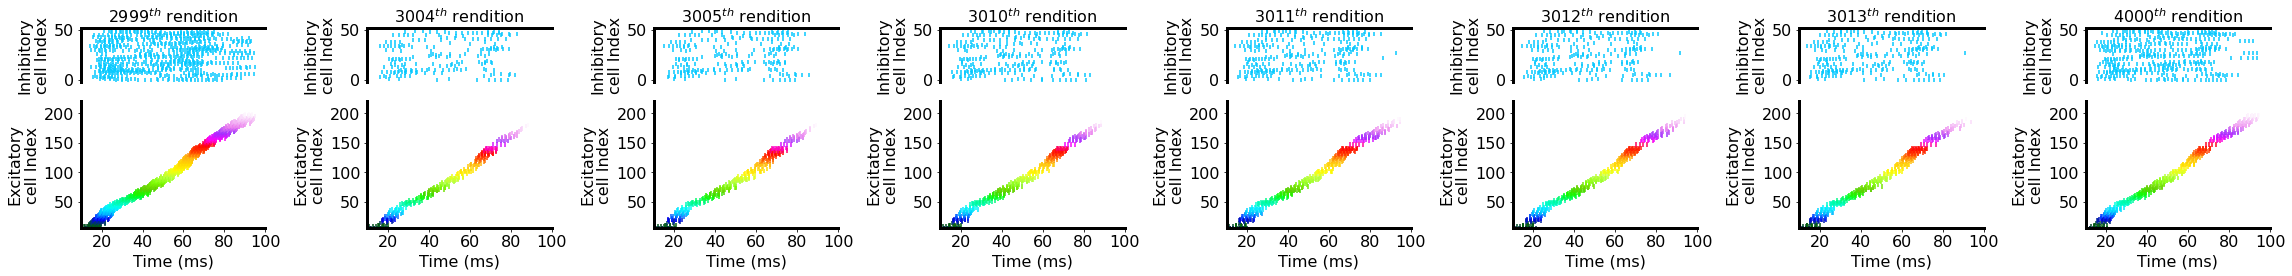

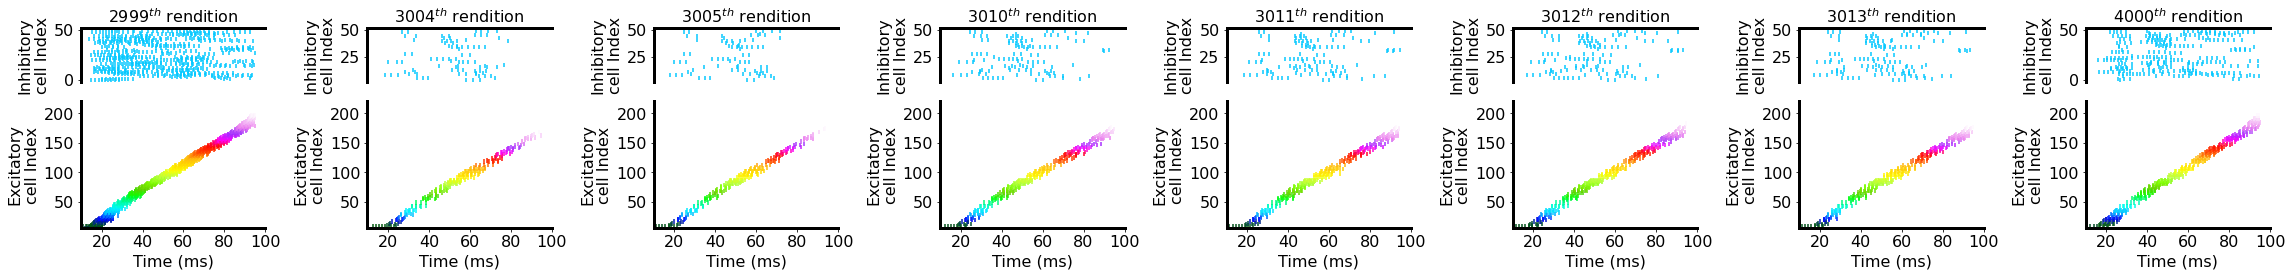

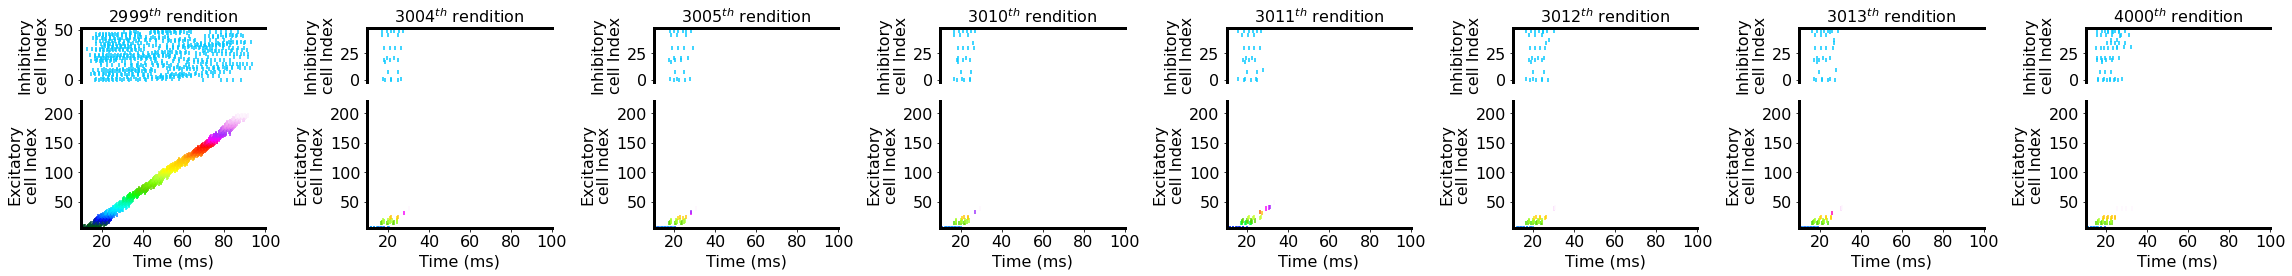

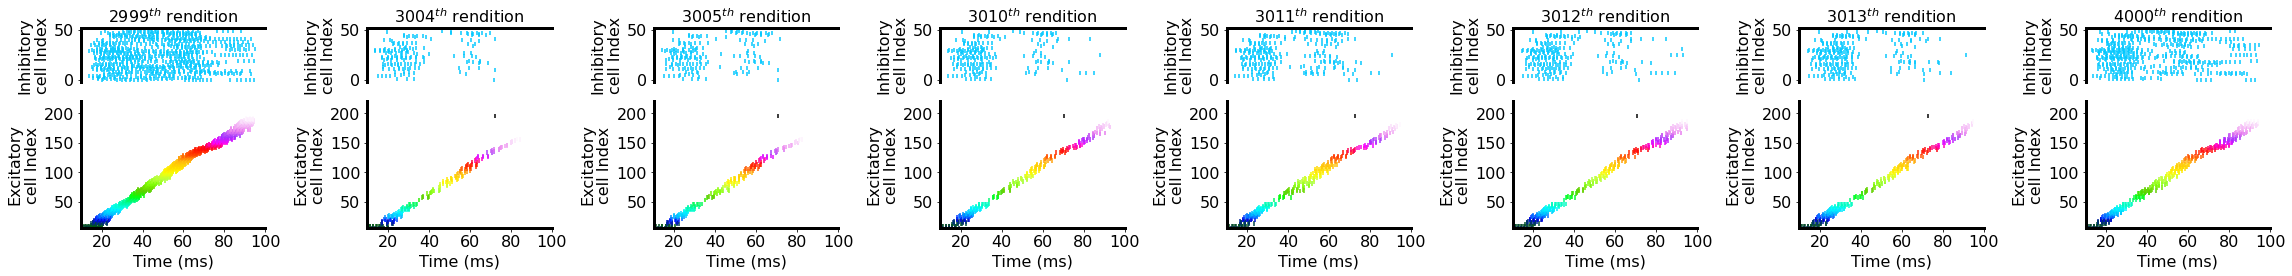

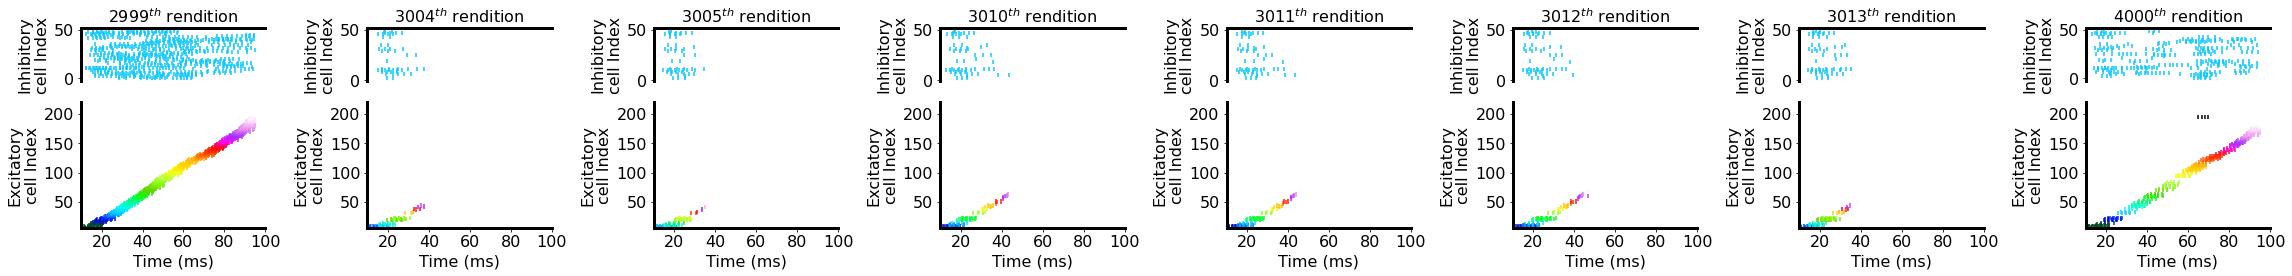

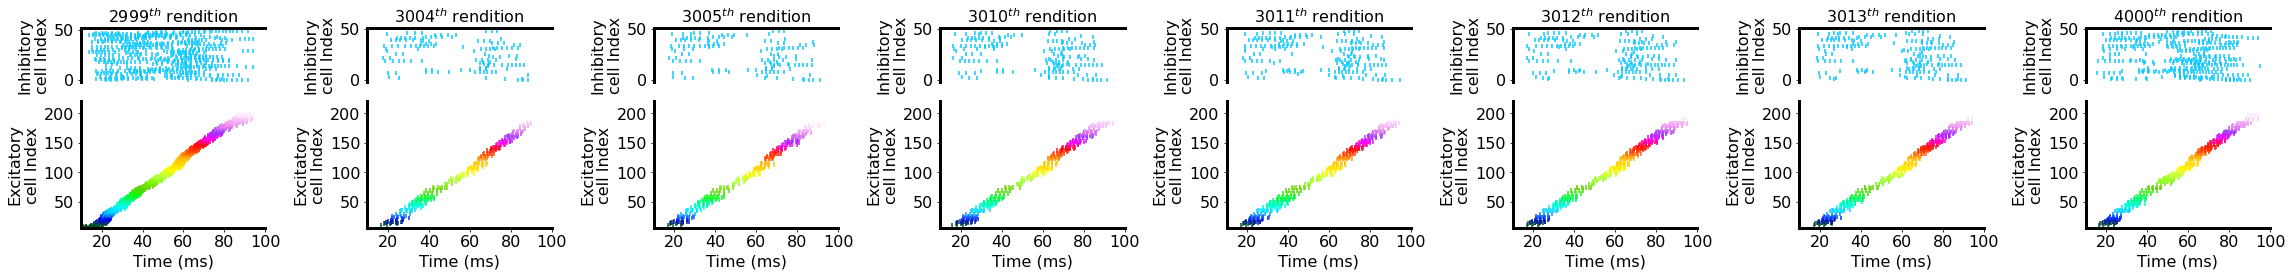

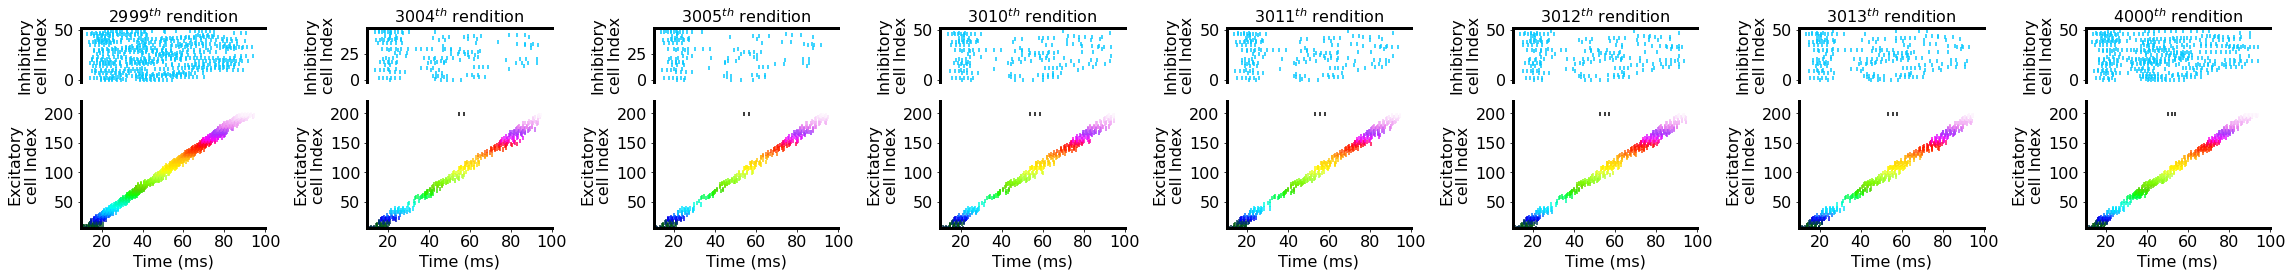

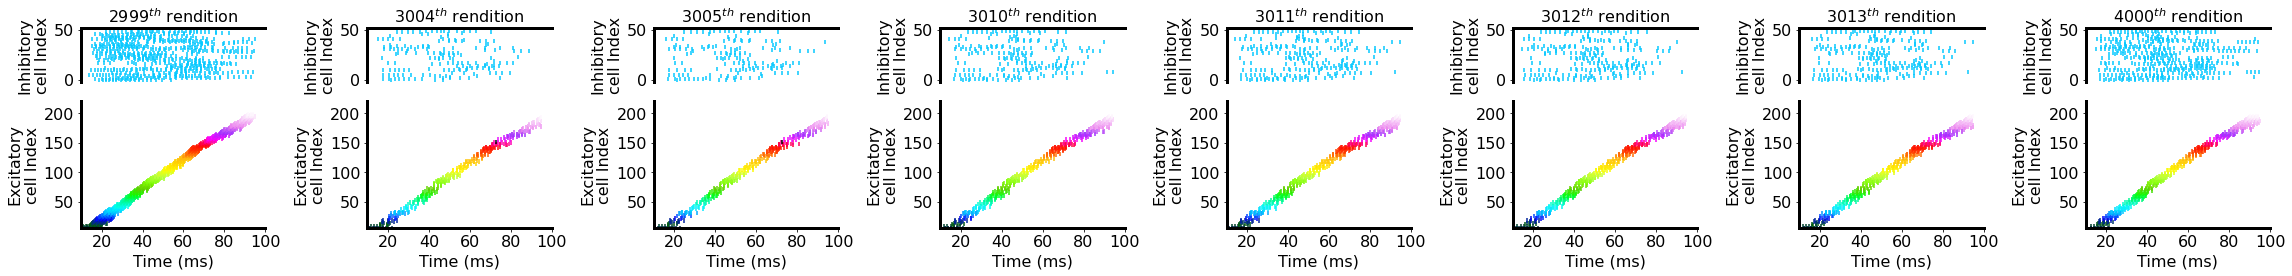

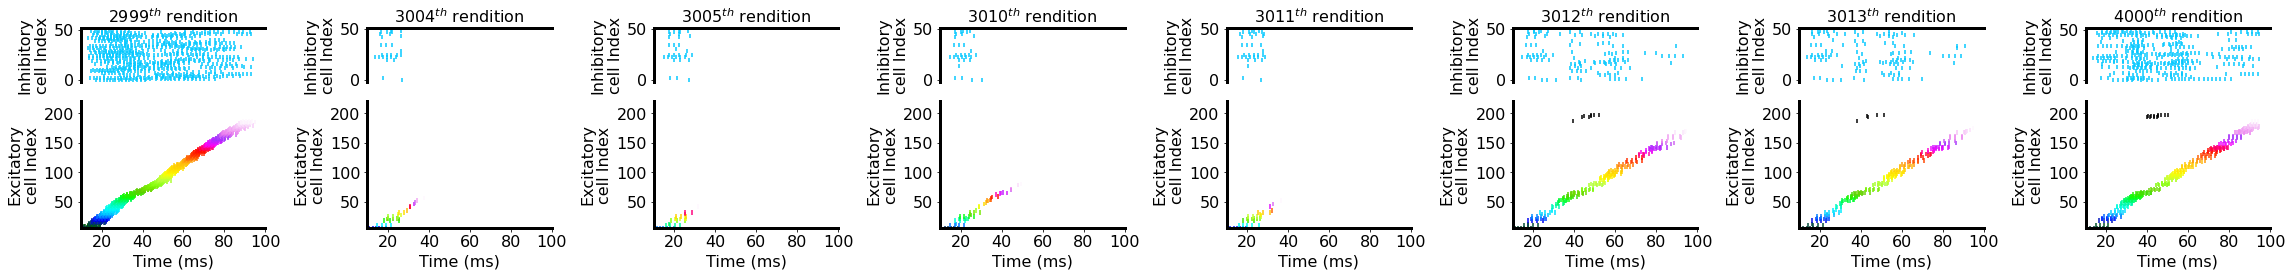

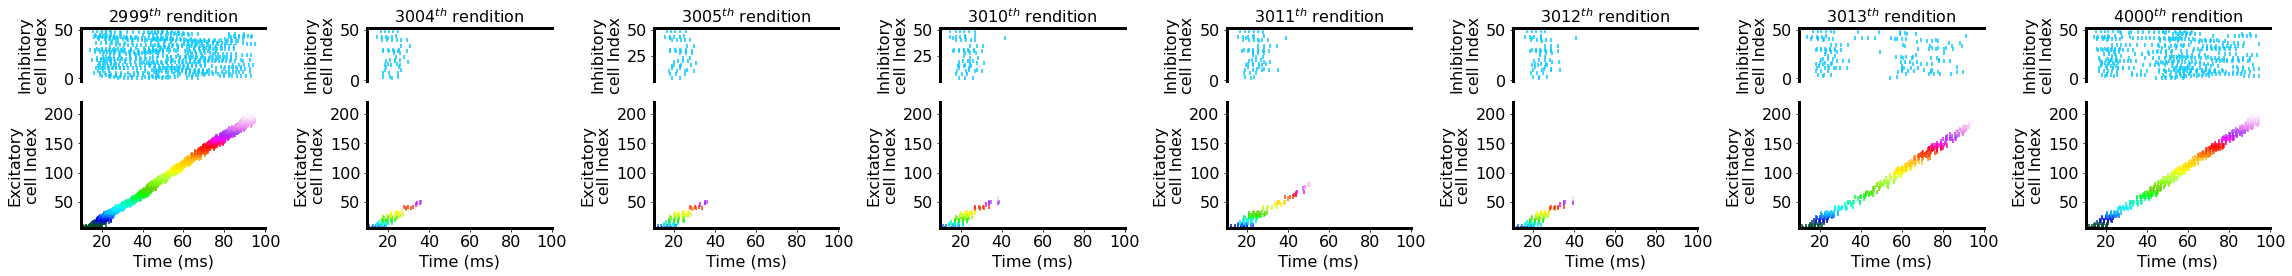

In [43]:
make_figure_1_sparse(
    ['reduced_ie', 'DROP_SEV_0.5', 'none'],
    cell_range=(0, 200),
    new_cell_idx=200,
    timepoints=[2999, 3004, 3005, 3010, 3011, 3012, 3013, 4000],
    sort_timepoint=2900,
    per_shown=1,
    color='#c41f3b',
)

reduced_ie_SEED_7000_W_E_E_0.0004_W_E_I_3.5e-05_W_I_E_4e-05_DROP_SEV_0.5_COMP_MECH_firing_rate_CONDITION_no_repl_no_syn_PER_SILENT_0_A5_5_2023-04-24--23:10--31:0552
2900
2999
3010
3011
3012
3013
4000
reduced_ie_SEED_7001_W_E_E_0.0004_W_E_I_3.5e-05_W_I_E_4e-05_DROP_SEV_0.5_COMP_MECH_firing_rate_CONDITION_no_repl_no_syn_PER_SILENT_0_A5_5_2023-04-24--23:10--31:4196
2900
2999
3010
3011
3012
3013
4000
reduced_ie_SEED_7002_W_E_E_0.0004_W_E_I_3.5e-05_W_I_E_4e-05_DROP_SEV_0.5_COMP_MECH_firing_rate_CONDITION_no_repl_no_syn_PER_SILENT_0_A5_5_2023-04-24--23:10--31:8110
2900
2999
3010
3011
3012
3013
4000
reduced_ie_SEED_7003_W_E_E_0.0004_W_E_I_3.5e-05_W_I_E_4e-05_DROP_SEV_0.5_COMP_MECH_firing_rate_CONDITION_no_repl_no_syn_PER_SILENT_0_A5_5_2023-04-24--23:10--31:2586
2900
2999
3010
3011
3012
3013
4000
reduced_ie_SEED_7004_W_E_E_0.0004_W_E_I_3.5e-05_W_I_E_4e-05_DROP_SEV_0.5_COMP_MECH_firing_rate_CONDITION_no_repl_no_syn_PER_SILENT_0_A5_5_2023-04-24--23:10--31:7863
2900
2999
3010
3011
3012
3013
4000


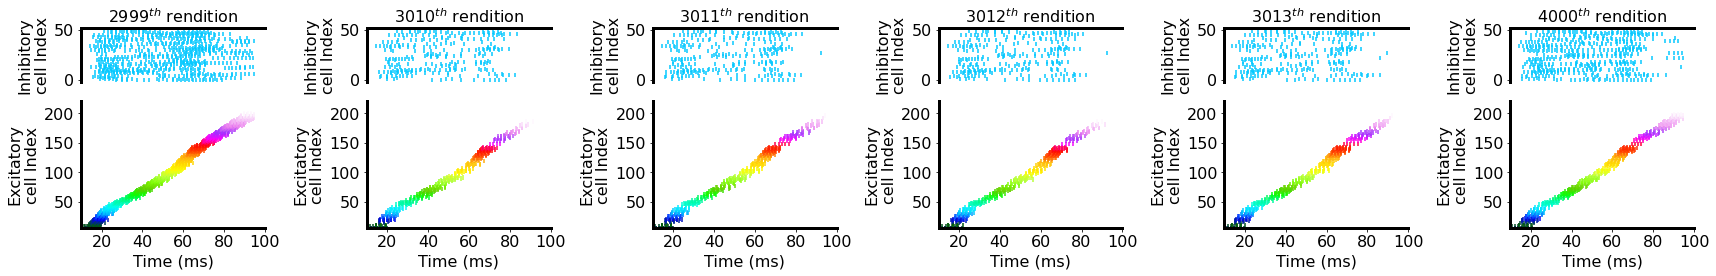

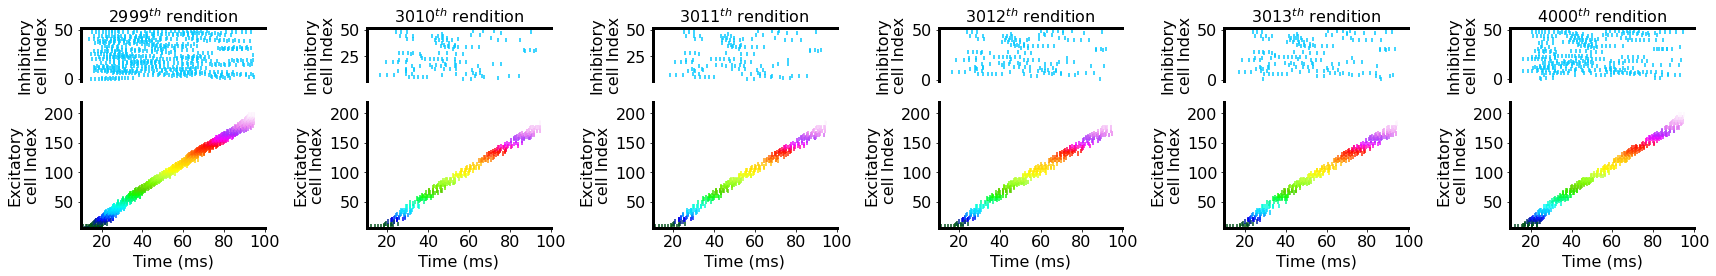

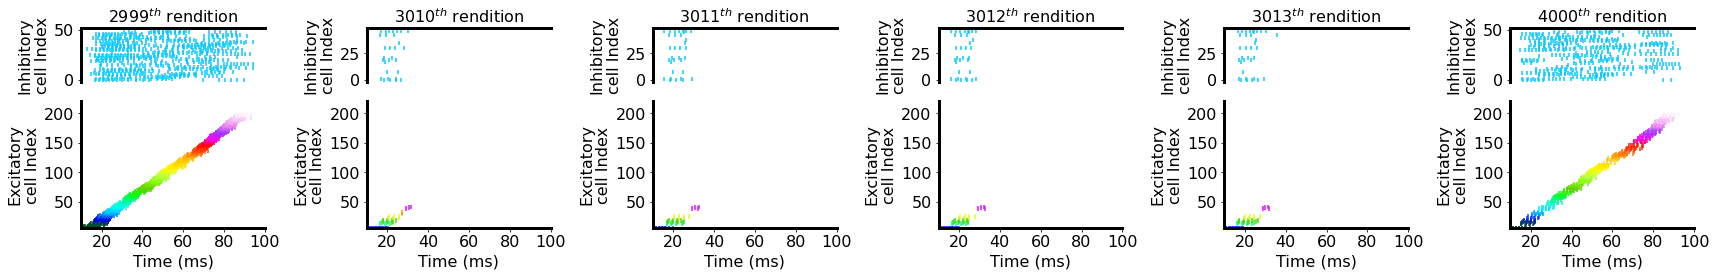

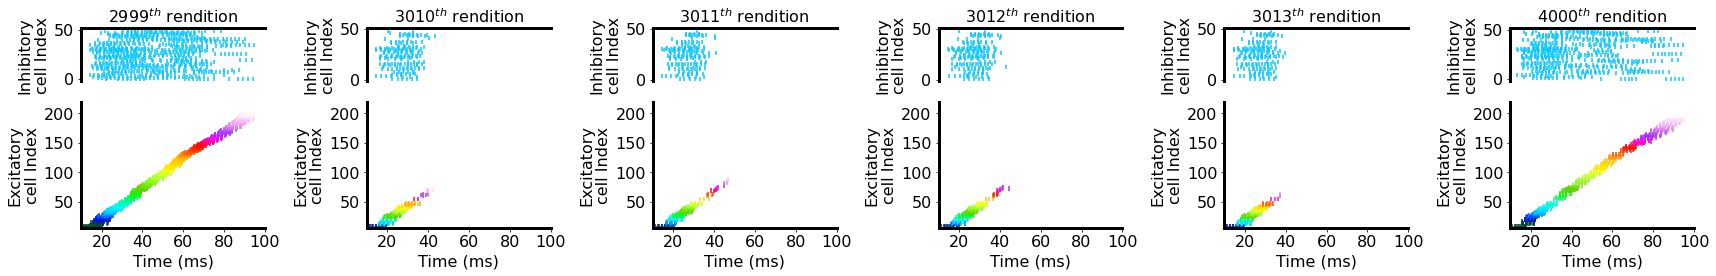

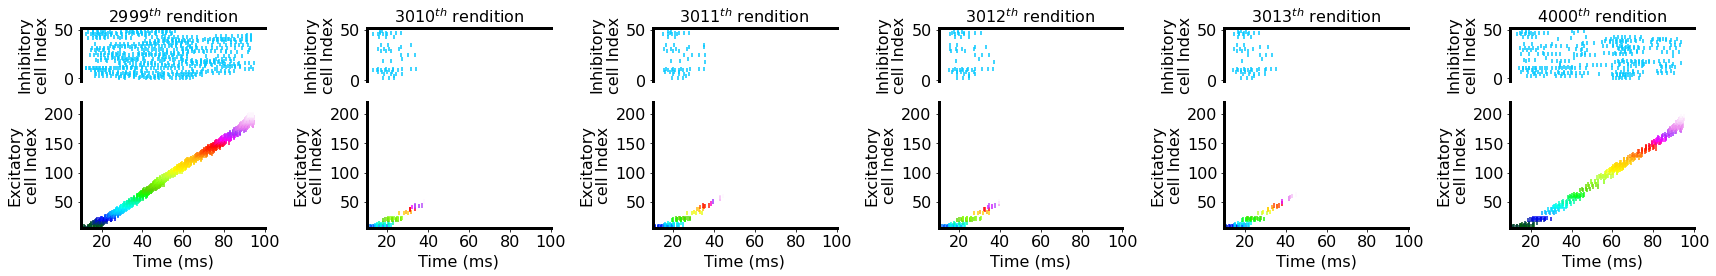

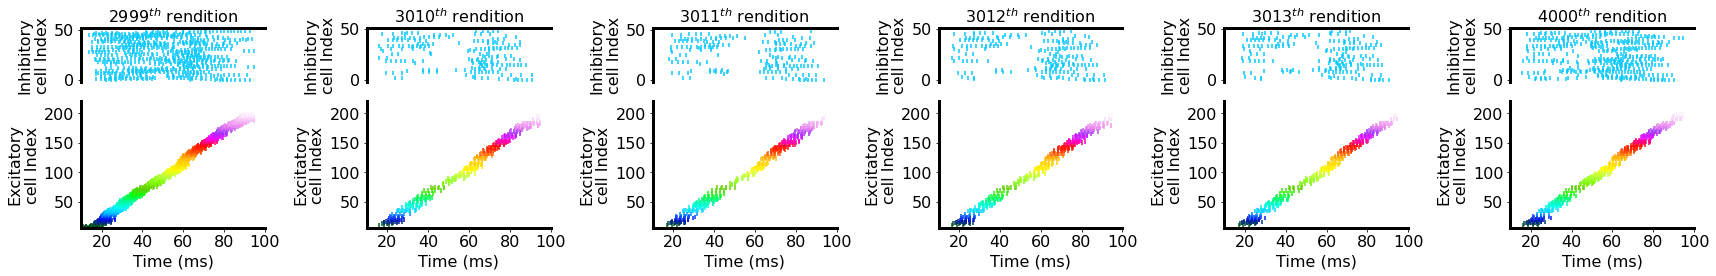

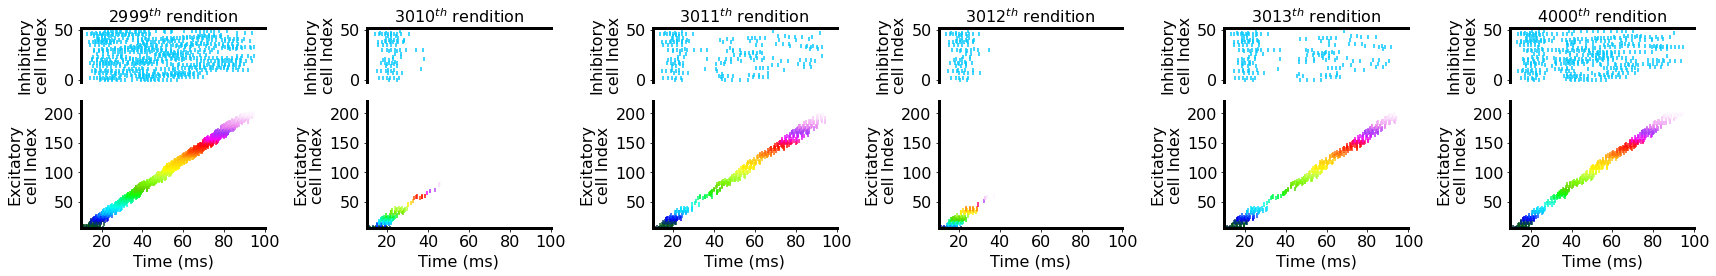

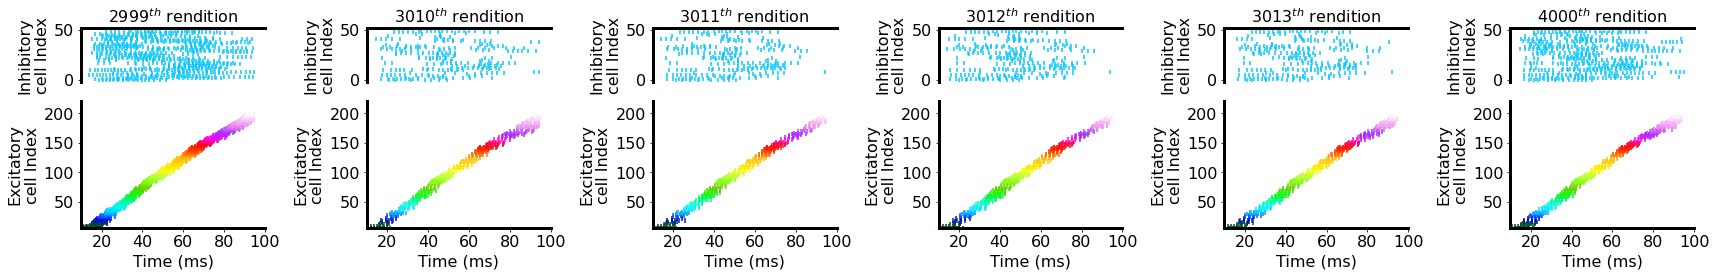

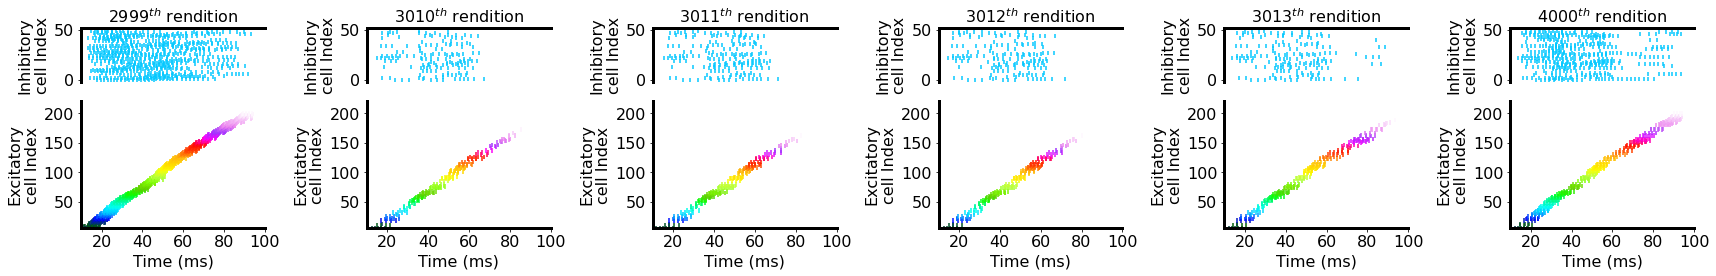

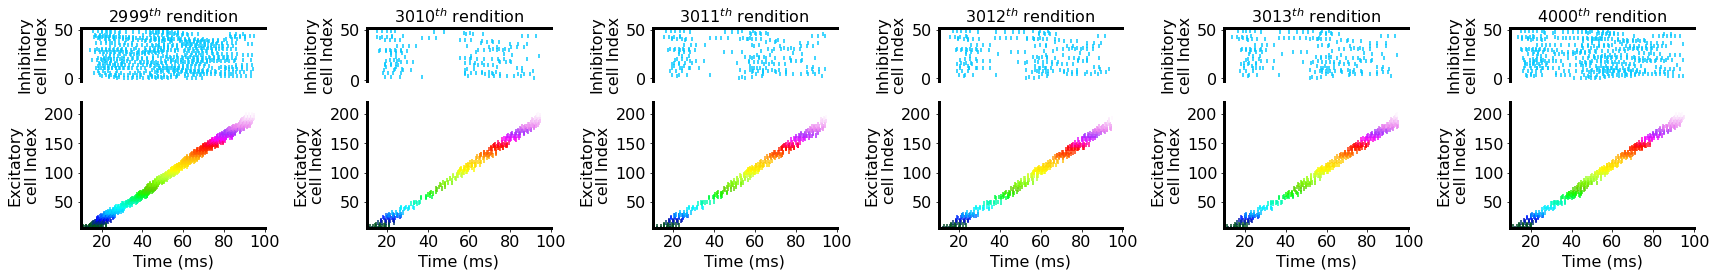

In [54]:
make_figure_1_sparse(
    ['reduced_ie', 'DROP_SEV_0.5', 'firing_rate'],
    cell_range=(0, 200),
    new_cell_idx=200,
    timepoints=[2999, 3010, 3011, 3012, 3013, 4000],
    sort_timepoint=2900,
    per_shown=1,
    color='#c41f3b',
)

In [44]:
def make_timing_comparison_graphs(name, cell_range=(0, 900), new_cell_idx=None, per_shown=1.,
                         layer_size=10, timepoints_pre=[], timepoints_post=[],
                         color='black', share_y_axis=False, show_inh=True, labels=None, fig_name=''):
    n_cells = cell_range[1] - cell_range[0]
    
    colors = ['', '#3503fc', '#fc8003', '#04cf1c'] #get_equally_spaced_colors(10, cmap='tab20')
    
    scale = 1
    fig = plt.figure(constrained_layout=True, figsize=(12 * scale, 4 * scale))
    gs = gridspec.GridSpec(ncols=3, nrows=1, figure=fig)
    axs = [fig.add_subplot(gs[0]), fig.add_subplot(gs[1]), fig.add_subplot(gs[2])]
    
    def rendition_label(n):
        if n == 0:
            n = 1
            return f'{n}' + r'$^{st}$ rendition'
        else:
            return f'{n}' + r'$^{th}$ rendition'
        
    if type(name) is list:
        all_dirs = filter_list_by_name_frags(all_in_dir('./robustness'), name)
    else:
        all_dirs = filter_list_by_name_frags(all_in_dir('./robustness'), [name])
        
    count = 0
    all_time_shifts = []
    all_std_first_spk_times_pre = []
    all_std_first_spk_times_post = []
    
    for d_idx, exp_dir_name in enumerate(all_dirs):
        if exp_dir_name not in recovered_exp_names:
            continue
#         if count >= 3:
#             break
        print(exp_dir_name)
        count += 1
        
#         if labels is None:
#             timepoint_names = [rendition_label(t) for t in timepoints]
#         else:
#             timepoint_names = labels
        
        cell_idxs_to_show = None
        cell_idx_names = None
        sorted_order = None
        
        first_spk_times_pre = []
        first_spk_times_post = []
        
        timepoints_to_fetch = np.unique(np.concatenate([timepoints_pre, timepoints_post]))
        timepoints_to_fetch.sort()

        j = 0
        for i, data in load_exp_data(os.path.join('./robustness', exp_dir_name), timepoints_to_fetch, n_exc=n_cells, new_cell_idx=new_cell_idx, name_frags=[], reverse=False):
            if i in timepoints_pre:
                first_spk_times_pre.append(data['first_spk_times'])
            
            if i in timepoints_post:
                first_spk_times_post.append(data['first_spk_times'])
        
        all_first_spk_times_pre = np.stack(first_spk_times_pre)
        all_first_spk_times_post = np.stack(first_spk_times_post)

        initial_time_mask = np.zeros(all_first_spk_times_pre.shape[1]).astype(bool)
        initial_time_mask[:40] = True
        initial_time_mask = np.logical_and(initial_time_mask, np.nanmean(all_first_spk_times_pre, axis=0) > 0)
#         print(np.count_nonzero(initial_time_mask))
        
        all_first_spk_times_pre -= np.nanmedian(all_first_spk_times_pre[:, initial_time_mask], axis=1).reshape(len(timepoints_pre), 1)
        all_first_spk_times_post -= np.nanmedian(all_first_spk_times_post[:, initial_time_mask], axis=1).reshape(len(timepoints_post), 1)
        
        mean_initial_time = np.nanmean(all_first_spk_times_pre, axis=0)
        all_first_spk_times_post = np.where(~np.isnan(mean_initial_time), all_first_spk_times_post, np.nan)
        mean_post_time = np.nanmean(all_first_spk_times_post, axis=0)
        
        std_initial_time = np.nanstd(all_first_spk_times_pre, axis=0)
        std_post_time = np.nanstd(all_first_spk_times_post, axis=0)
        
        all_std_first_spk_times_pre.append(std_initial_time)
        all_std_first_spk_times_post.append(std_post_time)
        
        time_shifts = mean_post_time - mean_initial_time
        all_time_shifts.append(time_shifts)
        
        if count < 4:
            axs[0].scatter(1000 * mean_initial_time, 1000 * time_shifts, color=colors[count], s=4)
            # axs[1].scatter(1000 * mean_initial_time, 1000 * std_initial_time, color=colors[count], s=2)
            # axs[2].scatter(1000 * mean_initial_time[~np.isnan(std_post_time)], 1000 * std_post_time[~np.isnan(std_post_time)], color=colors[count], s=2)
            
    
    all_time_shifts = np.stack(all_time_shifts)
    time_shift_means = np.nanmean(all_time_shifts, axis=0)
    time_shift_stds = np.nanstd(all_time_shifts, axis=0)
    y_upper = time_shift_means + time_shift_stds
    y_lower = time_shift_means - time_shift_stds
    
    for c_idx in range(0, all_time_shifts.shape[1], 20):
        axs[1].scatter(c_idx + np.random.normal(size=all_time_shifts.shape[0], scale=2), 1000 * all_time_shifts[:, c_idx], edgecolor='black', marker='o', facecolor='none')
    
    axs[2].scatter(np.arange(all_time_shifts.shape[1]), 1000 * np.nanmedian(np.stack(all_std_first_spk_times_pre), axis=0), color='black', s=4)
    axs[2].scatter(np.arange(all_time_shifts.shape[1]), 1000 * np.nanmedian(np.stack(all_std_first_spk_times_post), axis=0), color='red', s=4)
    
    axs[0].set_xlabel('Mean initial\nfirst spike time (ms)')
    axs[0].set_ylabel('Mean change in\nfirst spike time (ms)')
    
    axs[1].set_xlabel('Cell index')
    axs[1].set_ylabel('Mean change in first spike\ntime across all networks (ms)')
    
    axs[2].set_xlabel('Cell index')
    axs[2].set_ylabel('Median jitter in first spike\ntime across all networks (ms)')

    axs[0].set_ylim(-5, 5)
    axs[1].set_ylim(-5, 5)
    axs[2].set_ylim(0, 1.5)

    axs[0].set_xlim(0)
    axs[1].set_xlim(-5)
    axs[2].set_xlim(10)
    
    for i in range(3):
        set_font_size(axs[i], 14)
        axs[i].spines['top'].set_visible(False)
        axs[i].spines['right'].set_visible(False)
        
    fig.tight_layout()  
    save_fig(fig, './figures/paper/timing_analysis', f'{fig_name}.svg')
    save_fig(fig, './figures/paper/timing_analysis', f'{fig_name}.png')

reduced_ie_SEED_7005_W_E_E_0.0004_W_E_I_3.5e-05_W_I_E_4e-05_DROP_SEV_0.5_COMP_MECH_secreted_regulation_CONDITION_no_repl_no_syn_PER_SILENT_0.4_A5_5_2023-04-24--23:08--46:7060
reduced_ie_SEED_7008_W_E_E_0.0004_W_E_I_3.5e-05_W_I_E_4e-05_DROP_SEV_0.5_COMP_MECH_secreted_regulation_CONDITION_no_repl_no_syn_PER_SILENT_0.4_A5_5_2023-04-24--23:08--46:3797
reduced_ie_SEED_7007_W_E_E_0.0004_W_E_I_3.5e-05_W_I_E_4e-05_DROP_SEV_0.5_COMP_MECH_secreted_regulation_CONDITION_no_repl_no_syn_PER_SILENT_0.4_A5_5_2023-04-24--23:08--46:9962
reduced_ie_SEED_7004_W_E_E_0.0004_W_E_I_3.5e-05_W_I_E_4e-05_DROP_SEV_0.5_COMP_MECH_secreted_regulation_CONDITION_no_repl_no_syn_PER_SILENT_0.4_A5_5_2023-04-24--23:08--43:7863
reduced_ie_SEED_7000_W_E_E_0.0004_W_E_I_3.5e-05_W_I_E_4e-05_DROP_SEV_0.5_COMP_MECH_secreted_regulation_CONDITION_no_repl_no_syn_PER_SILENT_0.4_A5_5_2023-04-24--23:08--43:0552
reduced_ie_SEED_7009_W_E_E_0.0004_W_E_I_3.5e-05_W_I_E_4e-05_DROP_SEV_0.5_COMP_MECH_secreted_regulation_CONDITION_no_repl_no_s

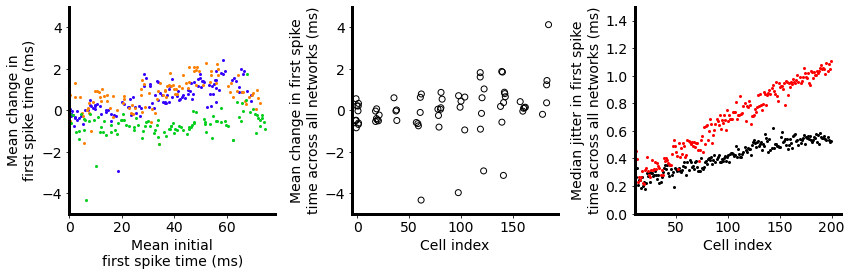

In [62]:
make_timing_comparison_graphs(
    ['reduced_ie', 'DROP_SEV_0.5', 'secreted_regulation'],
    cell_range=(0, 200),
    new_cell_idx=200,
    timepoints_pre=np.arange(2900, 2999),
    timepoints_post=np.arange(4900, 5000),
    color='#c41f3b',
    fig_name='population_silent_drop_point5',
)

In [47]:
def make_new_cell_variance_graphs(name, cell_range=(0, 900), new_cell_idx=None, per_shown=1.,
                         layer_size=10, timepoints_pre=[], timepoints_post_set=[],
                         color='black', share_y_axis=False, show_inh=True, labels=None, fig_name=''):
    n_cells = cell_range[1] - cell_range[0]
    
    colors = get_equally_spaced_colors(20, cmap='gist_ncar')
    
    scale = 2
    fig = plt.figure(constrained_layout=True, figsize=(4 * scale, 4 * scale))
    gs = gridspec.GridSpec(ncols=1, nrows=1, figure=fig)
    axs = [fig.add_subplot(gs[0])]
    
    def rendition_label(n):
        if n == 0:
            n = 1
            return f'{n}' + r'$^{st}$ rendition'
        else:
            return f'{n}' + r'$^{th}$ rendition'
        
    if type(name) is list:
        all_dirs = filter_list_by_name_frags(all_in_dir('./robustness'), name)
    else:
        all_dirs = filter_list_by_name_frags(all_in_dir('./robustness'), [name])
        
    count = 0
    bins = None
    initial_jitter_freqs = None
    final_jitter_freqs_set = []
    
    colors = get_equally_spaced_colors(20, cmap='gist_ncar')
    
    for d_idx, exp_dir_name in enumerate(sorted(all_dirs)):
        if exp_dir_name not in recovered_exp_names:
            continue
#         if count >= 3:
#             break
        print(exp_dir_name)
        count += 1
        
#         if labels is None:
#             timepoint_names = [rendition_label(t) for t in timepoints]
#         else:
#             timepoint_names = labels
        
        cell_idxs_to_show = None
        cell_idx_names = None
        sorted_order = None
        
        first_spk_times_pre = []
        first_spk_times_post_set = [[] for l in range(len(timepoints_post_set))]
        
        timepoints_to_fetch = np.unique(np.concatenate([timepoints_pre] + timepoints_post_set))
        timepoints_to_fetch.sort()

        j = 0
        for i, data in load_exp_data(os.path.join('./robustness', exp_dir_name), timepoints_to_fetch, n_exc=n_cells, new_cell_idx=new_cell_idx, name_frags=[], reverse=False):
            if i in timepoints_pre:
                first_spk_times_pre.append(data['first_spk_times'])
            
            for l in range(len(timepoints_post_set)):
                timepoints_post = timepoints_post_set[l]
                if i in timepoints_post:
                    first_spk_times_post_set[l].append(data['first_spk_times'])
        
        all_first_spk_times_pre = np.stack(first_spk_times_pre)
        all_first_spk_times_post_set = [np.stack(first_spk_times_post) for first_spk_times_post in first_spk_times_post_set]

        initial_time_mask = np.zeros(all_first_spk_times_pre.shape[1]).astype(bool)
        initial_time_mask[:40] = True
        initial_time_mask = np.logical_and(initial_time_mask, np.nanmean(all_first_spk_times_pre, axis=0) > 0)
        
        all_first_spk_times_pre -= np.nanmedian(all_first_spk_times_pre[:, initial_time_mask], axis=1).reshape(len(timepoints_pre), 1)
        for all_first_spk_times_post in all_first_spk_times_post_set:
            all_first_spk_times_post -= np.nanmedian(all_first_spk_times_post[:, initial_time_mask], axis=1).reshape(len(timepoints_post), 1)
        
        mean_initial_time = np.nanmean(all_first_spk_times_pre, axis=0)
        for l in range(len(timepoints_post_set)):
            all_first_spk_times_post_set[l] = np.where(np.isnan(mean_initial_time), all_first_spk_times_post_set[l], np.nan)
        
        mean_post_time_set = [np.nanmean(all_first_spk_times_post, axis=0) for all_first_spk_times_post in all_first_spk_times_post_set]
        
        std_initial_time = np.nanstd(all_first_spk_times_pre, axis=0)
        
        std_post_time = np.nanstd(all_first_spk_times_post, axis=0)
        std_post_time_set = [np.nanstd(all_first_spk_times_post, axis=0) for all_first_spk_times_post in all_first_spk_times_post_set]
        
        # axs[0].scatter(1000 * mean_initial_time[~np.isnan(std_initial_time)], 1000 * std_initial_time[~np.isnan(std_initial_time)], color=colors[count], s=2)
        bins, freqs = bin_occurrences(1000 * std_initial_time[~np.isnan(std_initial_time)], bin_size=1, max_val=50)
#         axs[0].plot(bins, freqs, color=colors[count], lw=1)
        if initial_jitter_freqs is None:
            initial_jitter_freqs = freqs
        else:
            initial_jitter_freqs += freqs

        for l in range(len(timepoints_post_set)):
            non_nan_std_post_times_l = std_post_time_set[l][~np.isnan(std_post_time_set[l])]
            bins, freqs = bin_occurrences(1000 * non_nan_std_post_times_l, bin_size=1, max_val=50)
            if len(final_jitter_freqs_set) <= l:
                final_jitter_freqs_set.append(freqs)
            else:
                final_jitter_freqs_set[l] += freqs
#             axs[1 + l].plot(bins, freqs, color=colors[count], lw=1)
            # axs[1 + l].scatter(1000 * mean_post_time_set[l][~np.isnan(std_post_time_set[l])], 1000 * non_nan_std_post_times_l, color=colors[count], s=2)

    axs[0].plot(bins, initial_jitter_freqs, color='black', lw=1)
#     for l in range(len(timepoints_post_set)):
    axs[0].plot(bins, final_jitter_freqs_set[0], color='red', lw=1)
    axs[0].plot(bins, final_jitter_freqs_set[1], color='blue', lw=1)
    
#     time_shift_stds = np.nanstd(all_time_shifts, axis=0)
#     y_upper = time_shift_means + time_shift_stds
#     y_lower = time_shift_means - time_shift_stds
    
#     axs[3].scatter(np.arange(all_time_shifts.shape[1]), 1000 * np.nanmean(all_time_shifts, axis=0), color='black', s=2)
#     axs[3].scatter(np.arange(all_time_shifts.shape[1]), 1000 * np.nanmean(np.stack(all_std_first_spk_times_pre), axis=0), color='red', s=2)
#     axs[3].scatter(np.arange(all_time_shifts.shape[1]), 1000 * np.nanmean(np.stack(all_std_first_spk_times_post), axis=0), color='#9e0b17', s=2)
    
    axs[0].set_xlabel('Mean first\n spike time (ms)')
    axs[0].set_ylabel('STD first\nspike time (ms)')
    
#     axs[2].set_xlabel('Mean recovered\nfirst spike time (ms)')
#     axs[2].set_ylabel('STD recovered first\nspike time (ms)')
    
#     axs[3].set_ylabel('Milliseconds')
#     axs[3].set_xlabel('Cell index')
#     axs[0].set_ylim(-5, 5)
#     axs[1].set_ylim(0, 2.5)
#     axs[2].set_ylim(0, 2.5)
#     axs[3].set_ylim(-4, 4)
    axs[0].set_xlim(0)
    axs[0].set_ylim(0)
#     axs[1].set_xlim(12)
#     axs[2].set_xlim(12)
#     axs[3].set_xlim(12)
    
    for i in range(1):
        set_font_size(axs[i], 14)
        axs[i].spines['top'].set_visible(False)
        axs[i].spines['right'].set_visible(False)
#         axs[i].set_xlim(0, 50)
#         if i > 0:
#             axs[i].set_ylim(0, 50)
#         else:
#             axs[i].set_ylim(0)
        
    fig.tight_layout()  
    save_fig(fig, './figures/paper/timing_analysis', f'{fig_name}.svg')
    save_fig(fig, './figures/paper/timing_analysis', f'{fig_name}.png')

ValueError: x, y, and format string must not be None

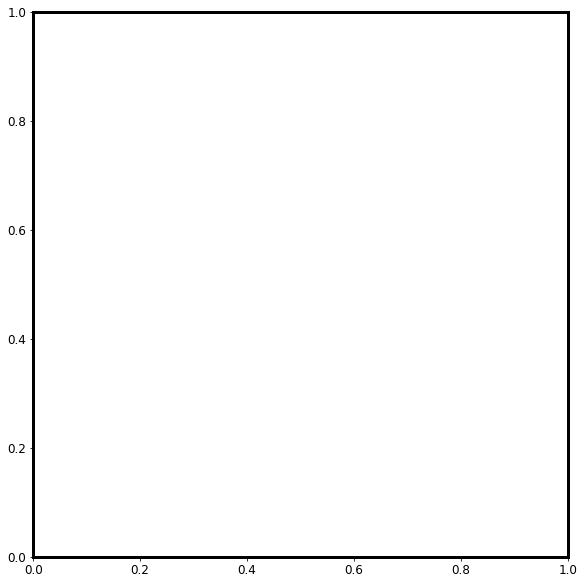

In [48]:
make_new_cell_variance_graphs(
    ['additive', 'DROP_SEV_0.4', 'secreted_regulation', '2023-04-09'],
    cell_range=(0, 200),
    new_cell_idx=200,
    timepoints_pre=np.arange(1500, 1999),
    timepoints_post_set=[np.arange(2000, 2499), np.arange(3000, 3499), np.arange(6000, 6499)],
    color='#c41f3b',
    fig_name='firing_rate',
)

In [49]:
def make_total_activity_plot(names, labels, condition_colors, n_excs=[450], file_name_ext='', ylim1=None, ylim2=None,
                       ylabel1=None, ylabel2=None, timepoints=[], offsets=[], vertical_spacing=0.,
                       axs=None, fig=None, tick_right=True, legend=True):
    scale = 1.5
    
    if fig is None:
        fig, axs = plt.subplots(1, 2, sharex=True, sharey=False, figsize=(6 * scale, 2.5 * scale))
    
    all_dirs = []
    for name in names:
        if type(name) is not list:
            name = [name]
        print(name)
        all_dirs.append([dirs for dirs in filter_list_by_name_frags(all_in_dir('./robustness'), name)])
        
    timepoints = np.array(timepoints)
        
    for idx, exp_dir_names in enumerate(all_dirs):
        e_activity = []
        i_activity = []
        
        count = 0
        for j, exp_dir_name in enumerate(exp_dir_names):
            if exp_dir_name not in recovered_exp_names:
                continue

            print(exp_dir_name)
                    
            all_mean_e_activity = []
            all_mean_i_activity = []
            baseline_mean_e = []
            baseline_mean_i = []

            for i, data in load_exp_data(os.path.join('./robustness', exp_dir_name), timepoints, n_exc=n_excs[idx], name_frags=[], new_cell_idx=200):
                
                all_mean_e_activity.append(len(data['exc_raster_unperturbed'][0, :]))
                all_mean_i_activity.append(len(data['inh_raster'][0, :]))
                
                if i >= offsets[idx] - 100 and i < offsets[idx]:
                    baseline_mean_e.append(len(data['exc_raster_unperturbed'][0, :]))
                    baseline_mean_i.append(len(data['inh_raster'][0, :]))
            
            all_mean_e_activity = np.array(all_mean_e_activity) / np.mean(baseline_mean_e)
            all_mean_i_activity = np.array(all_mean_i_activity) / np.mean(baseline_mean_i)
            
#             if np.max(all_mean_e_activity[:5]) < 1.2 and np.max(all_mean_i_activity[:5]) < 1.2:
            e_activity.append(all_mean_e_activity)
            i_activity.append(all_mean_i_activity)
            count += 1

#             axs[0].plot(timepoints[:len(all_mean_e_activity)], all_mean_e_activity, color=condition_colors[idx][0], lw=0.5, zorder=-1)
#             axs[1].plot(timepoints[:len(all_mean_i_activity)], all_mean_i_activity, color=condition_colors[idx][1], lw=0.5, zorder=-1)
        
        e_means = safe_apply_stat(e_activity, np.mean)
        e_sems = safe_apply_stat(e_activity, lambda x: np.std(x) / np.sqrt(len(x)))
        i_means = safe_apply_stat(i_activity, np.mean)
        i_sems = safe_apply_stat(i_activity, lambda x: np.std(x) / np.sqrt(len(x)))

        y_disp = vertical_spacing * idx
        trimmed_timepoints = timepoints[:len(e_means)]

        axs[0].fill_between(
            trimmed_timepoints,
            e_means - e_sems + y_disp,
            e_means + e_sems + y_disp,
            color=condition_colors[idx][0], alpha=0.2, zorder=0)
        axs[0].plot(trimmed_timepoints, e_means + y_disp, lw=1.5, color=condition_colors[idx][0], label=labels[idx], zorder=0)
        axs[1].fill_between(
            trimmed_timepoints,
            i_means - i_sems + y_disp,
            i_means + i_sems + y_disp,
            color=condition_colors[idx][1], alpha=0.2, zorder=-1)
        axs[1].plot(trimmed_timepoints, i_means + y_disp, lw=1.5, color=condition_colors[idx][1], label=labels[idx], zorder=-1)

        if ylabel1 is None:    
            axs[0].set_ylabel(r'Mean excitatory activity')
        else:
            axs[0].set_ylabel(ylabel1)
            
        if ylabel2 is None:  
            axs[1].set_ylabel(r'Mean inhibitory activity')
        else:
            axs[1].set_ylabel(ylabel2)
        if ylim1 is not None:
                axs[0].set_ylim(ylim1[0], ylim1[1])
        if ylim2 is not None:
                axs[1].set_ylim(ylim2[0], ylim2[1])
                
        y_ticks = []
        y_tick_labels = []
        for i in range(len(names)):
            y_ticks.append(vertical_spacing * i + 0.5)
            y_ticks.append(vertical_spacing * i + 1)
            y_ticks.append(vertical_spacing * i + 1.5)
            y_tick_labels.append(0.5)
            y_tick_labels.append(1)
            y_tick_labels.append(1.5)
                
        for i in range(2):
            axs[i].set_xlim(timepoints[0], timepoints[-1])
            axs[i].set_ylim(0)
            axs[i].set_xlabel('Rendition number')
            if tick_right:
                axs[i].tick_params(right=True, labelright=True)
            set_font_size(axs[i], 14)
            axs[i].spines['right'].set_visible(False)
            axs[i].spines['top'].set_visible(False)
#             axs[i].set_yticks(y_ticks)
#             axs[i].set_yticklabels(y_tick_labels)
#     if legend:
#         axs[0].legend(loc='lower right')
    fig.tight_layout()
    save_fig(fig, './figures/paper/fig_2', f'mean_plot_{file_name_ext}.png')
    save_fig(fig, './figures/paper/fig_2', f'mean_plot_{file_name_ext}.svg')

['final', 'DROP_SEV_0.1', 'secreted_regulation', '2023-04-09']
['final', 'DROP_SEV_0.25', 'secreted_regulation', '2023-04-09']
['final', 'DROP_SEV_0.5', 'secreted_regulation', '2023-04-14']


ValueError: zero-size array to reduction operation maximum which has no identity

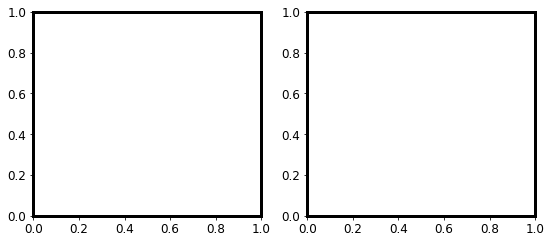

In [50]:
timepoints = np.concatenate([np.arange(2750, 3000, 10), np.arange(3000, 3020, 1), np.arange(3000, 6000, 10)])

make_total_activity_plot([
    ['final', 'DROP_SEV_0.1', 'secreted_regulation', '2023-04-09'],
    ['final', 'DROP_SEV_0.25', 'secreted_regulation', '2023-04-09'],
    ['final', 'DROP_SEV_0.5', 'secreted_regulation', '2023-04-14'],
],
    ['1', '2', '3'], color_sets, n_excs=[200, 200, 200], ylim1=None, ylim2=None,
    ylabel1=None, ylabel2=None, timepoints=np.arange(2750, 6000, 10), offsets=[2999, 2999, 2999], vertical_spacing=0.,
    tick_right=False, legend=True)

In [70]:
def make_total_activity_plot(names, labels, condition_colors, n_excs=[450], file_name_ext='', ylim1=None, ylim2=None,
                       ylabel1=None, ylabel2=None, timepoints=[], offsets=[], vertical_spacing=0.,
                       axs=None, fig=None, tick_right=True, legend=True):
    scale = 1.5
    
    if fig is None:
        fig, axs = plt.subplots(1, 2, sharex=True, sharey=False, figsize=(6 * scale, 2.5 * scale))
    
    all_dirs = []
    for name in names:
        if type(name) is not list:
            name = [name]
        print(name)
        all_dirs.append([dirs for dirs in filter_list_by_name_frags(all_in_dir('./robustness'), name)])
        
    timepoints = np.array(timepoints)
        
    for idx, exp_dir_names in enumerate(all_dirs):
        e_activity = []
        i_activity = []
        
        count = 0
        for j, exp_dir_name in enumerate(exp_dir_names):
            if exp_dir_name not in recovered_exp_names:
                continue

            print(exp_dir_name)
                    
            all_mean_e_activity = []
            all_mean_i_activity = []
            baseline_mean_e = []
            baseline_mean_i = []

            for i, data in load_exp_data(os.path.join('./robustness', exp_dir_name), timepoints, n_exc=n_excs[idx], name_frags=[], new_cell_idx=200):
                
                all_mean_e_activity.append(len(data['exc_raster_unperturbed'][0, :]))
                all_mean_i_activity.append(len(data['inh_raster'][0, :]))
                
                if i >= offsets[idx] - 100 and i < offsets[idx]:
                    baseline_mean_e.append(len(data['exc_raster_unperturbed'][0, :]))
                    baseline_mean_i.append(len(data['inh_raster'][0, :]))
            
            all_mean_e_activity = np.array(all_mean_e_activity) / np.mean(baseline_mean_e)
            all_mean_i_activity = np.array(all_mean_i_activity) / np.mean(baseline_mean_i)
            
#             if np.max(all_mean_e_activity[:5]) < 1.2 and np.max(all_mean_i_activity[:5]) < 1.2:
            e_activity.append(all_mean_e_activity)
            i_activity.append(all_mean_i_activity)
            count += 1

#             axs[0].plot(timepoints[:len(all_mean_e_activity)], all_mean_e_activity, color=condition_colors[idx][0], lw=0.5, zorder=-1)
#             axs[1].plot(timepoints[:len(all_mean_i_activity)], all_mean_i_activity, color=condition_colors[idx][1], lw=0.5, zorder=-1)
        
        e_means = safe_apply_stat(e_activity, np.mean)
        e_sems = safe_apply_stat(e_activity, lambda x: np.std(x) / np.sqrt(len(x)))
        i_means = safe_apply_stat(i_activity, np.mean)
        i_sems = safe_apply_stat(i_activity, lambda x: np.std(x) / np.sqrt(len(x)))

        y_disp = vertical_spacing * idx
        trimmed_timepoints = timepoints[:len(e_means)]

        axs[0].fill_between(
            trimmed_timepoints,
            e_means - e_sems + y_disp,
            e_means + e_sems + y_disp,
            color=condition_colors[idx][0], alpha=0.2, zorder=0)
        axs[0].plot(trimmed_timepoints, e_means + y_disp, lw=1.5, color=condition_colors[idx][0], label=labels[idx], zorder=0)
        axs[1].fill_between(
            trimmed_timepoints,
            i_means - i_sems + y_disp,
            i_means + i_sems + y_disp,
            color=condition_colors[idx][1], alpha=0.2, zorder=-1)
        axs[1].plot(trimmed_timepoints, i_means + y_disp, lw=1.5, color=condition_colors[idx][1], label=labels[idx], zorder=-1)

        if ylabel1 is None:    
            axs[0].set_ylabel(r'Mean excitatory activity')
        else:
            axs[0].set_ylabel(ylabel1)
            
        if ylabel2 is None:  
            axs[1].set_ylabel(r'Mean inhibitory activity')
        else:
            axs[1].set_ylabel(ylabel2)
        if ylim1 is not None:
                axs[0].set_ylim(ylim1[0], ylim1[1])
        if ylim2 is not None:
                axs[1].set_ylim(ylim2[0], ylim2[1])
                
        y_ticks = []
        y_tick_labels = []
        for i in range(len(names)):
            y_ticks.append(vertical_spacing * i + 0.5)
            y_ticks.append(vertical_spacing * i + 1)
            y_ticks.append(vertical_spacing * i + 1.5)
            y_tick_labels.append(0.5)
            y_tick_labels.append(1)
            y_tick_labels.append(1.5)
                
        for i in range(2):
            axs[i].set_xlim(timepoints[0], timepoints[-1])
            axs[i].set_ylim(0)
            axs[i].set_xlabel('Rendition number')
            if tick_right:
                axs[i].tick_params(right=True, labelright=True)
            set_font_size(axs[i], 14)
            axs[i].spines['right'].set_visible(False)
            axs[i].spines['top'].set_visible(False)
#             axs[i].set_yticks(y_ticks)
#             axs[i].set_yticklabels(y_tick_labels)
#     if legend:
#         axs[0].legend(loc='lower right')
    fig.tight_layout()
    save_fig(fig, './figures/paper/fig_2', f'mean_plot_{file_name_ext}.png')
    save_fig(fig, './figures/paper/fig_2', f'mean_plot_{file_name_ext}.svg')

['reduced_ie', 'DROP_SEV_0.5', 'secreted_regulation']
reduced_ie_SEED_7005_W_E_E_0.0004_W_E_I_3.5e-05_W_I_E_4e-05_DROP_SEV_0.5_COMP_MECH_secreted_regulation_CONDITION_no_repl_no_syn_PER_SILENT_0.4_A5_5_2023-04-24--23:08--46:7060
reduced_ie_SEED_7008_W_E_E_0.0004_W_E_I_3.5e-05_W_I_E_4e-05_DROP_SEV_0.5_COMP_MECH_secreted_regulation_CONDITION_no_repl_no_syn_PER_SILENT_0.4_A5_5_2023-04-24--23:08--46:3797
reduced_ie_SEED_7007_W_E_E_0.0004_W_E_I_3.5e-05_W_I_E_4e-05_DROP_SEV_0.5_COMP_MECH_secreted_regulation_CONDITION_no_repl_no_syn_PER_SILENT_0.4_A5_5_2023-04-24--23:08--46:9962
reduced_ie_SEED_7004_W_E_E_0.0004_W_E_I_3.5e-05_W_I_E_4e-05_DROP_SEV_0.5_COMP_MECH_secreted_regulation_CONDITION_no_repl_no_syn_PER_SILENT_0.4_A5_5_2023-04-24--23:08--43:7863
reduced_ie_SEED_7000_W_E_E_0.0004_W_E_I_3.5e-05_W_I_E_4e-05_DROP_SEV_0.5_COMP_MECH_secreted_regulation_CONDITION_no_repl_no_syn_PER_SILENT_0.4_A5_5_2023-04-24--23:08--43:0552
reduced_ie_SEED_7009_W_E_E_0.0004_W_E_I_3.5e-05_W_I_E_4e-05_DROP_SEV_0.

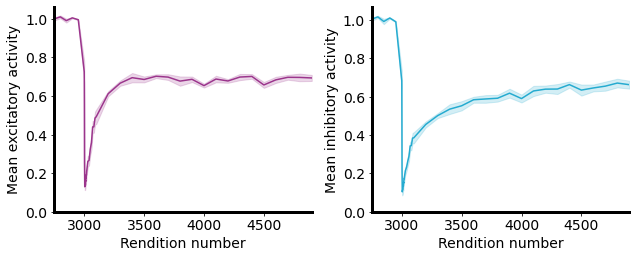

In [72]:
timepoints = np.concatenate([np.arange(2750, 3000, 50), np.arange(3000, 3020, 1), np.arange(3020, 3100, 10), np.arange(3100, 5000, 100)])

make_total_activity_plot([
    ['reduced_ie', 'DROP_SEV_0.5', 'secreted_regulation'],
],
    ['1', '2', '3'], color_sets, n_excs=[200, 200, 200], ylim1=None, ylim2=None,
    ylabel1=None, ylabel2=None, timepoints=timepoints, offsets=[2999, 2999, 2999], vertical_spacing=0.,
    tick_right=False, legend=True)

['reduced_ie', 'DROP_SEV_0.5', 'none']
reduced_ie_SEED_7006_W_E_E_0.0004_W_E_I_3.5e-05_W_I_E_4e-05_DROP_SEV_0.5_COMP_MECH_none_CONDITION_no_repl_no_syn_PER_SILENT_0_A5_5_2023-04-24--23:10--31:0410
reduced_ie_SEED_7007_W_E_E_0.0004_W_E_I_3.5e-05_W_I_E_4e-05_DROP_SEV_0.5_COMP_MECH_none_CONDITION_no_repl_no_syn_PER_SILENT_0_A5_5_2023-04-24--23:10--31:9962
reduced_ie_SEED_7001_W_E_E_0.0004_W_E_I_3.5e-05_W_I_E_4e-05_DROP_SEV_0.5_COMP_MECH_none_CONDITION_no_repl_no_syn_PER_SILENT_0_A5_5_2023-04-24--23:10--31:4196
reduced_ie_SEED_7000_W_E_E_0.0004_W_E_I_3.5e-05_W_I_E_4e-05_DROP_SEV_0.5_COMP_MECH_none_CONDITION_no_repl_no_syn_PER_SILENT_0_A5_5_2023-04-24--23:10--31:0552
reduced_ie_SEED_7005_W_E_E_0.0004_W_E_I_3.5e-05_W_I_E_4e-05_DROP_SEV_0.5_COMP_MECH_none_CONDITION_no_repl_no_syn_PER_SILENT_0_A5_5_2023-04-24--23:10--31:7060
reduced_ie_SEED_7004_W_E_E_0.0004_W_E_I_3.5e-05_W_I_E_4e-05_DROP_SEV_0.5_COMP_MECH_none_CONDITION_no_repl_no_syn_PER_SILENT_0_A5_5_2023-04-24--23:10--31:7863
reduced_ie_SE

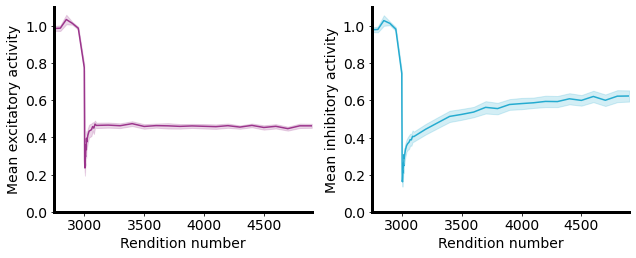

In [73]:
timepoints = np.concatenate([np.arange(2750, 3000, 50), np.arange(3000, 3020, 1), np.arange(3020, 3100, 10), np.arange(3100, 5000, 100)])

make_total_activity_plot([
    ['reduced_ie', 'DROP_SEV_0.5', 'none'],
],
    ['1', '2', '3'], color_sets, n_excs=[200, 200, 200], ylim1=None, ylim2=None,
    ylabel1=None, ylabel2=None, timepoints=timepoints, offsets=[2999, 2999, 2999], vertical_spacing=0.,
    tick_right=False, legend=True)

['reduced_ie', 'DROP_SEV_0.5', 'firing_rate']
reduced_ie_SEED_7000_W_E_E_0.0004_W_E_I_3.5e-05_W_I_E_4e-05_DROP_SEV_0.5_COMP_MECH_firing_rate_CONDITION_no_repl_no_syn_PER_SILENT_0_A5_5_2023-04-24--23:10--31:0552
reduced_ie_SEED_7001_W_E_E_0.0004_W_E_I_3.5e-05_W_I_E_4e-05_DROP_SEV_0.5_COMP_MECH_firing_rate_CONDITION_no_repl_no_syn_PER_SILENT_0_A5_5_2023-04-24--23:10--31:4196
reduced_ie_SEED_7007_W_E_E_0.0004_W_E_I_3.5e-05_W_I_E_4e-05_DROP_SEV_0.5_COMP_MECH_firing_rate_CONDITION_no_repl_no_syn_PER_SILENT_0_A5_5_2023-04-24--23:10--31:9962
reduced_ie_SEED_7009_W_E_E_0.0004_W_E_I_3.5e-05_W_I_E_4e-05_DROP_SEV_0.5_COMP_MECH_firing_rate_CONDITION_no_repl_no_syn_PER_SILENT_0_A5_5_2023-04-24--23:10--31:6509
reduced_ie_SEED_7008_W_E_E_0.0004_W_E_I_3.5e-05_W_I_E_4e-05_DROP_SEV_0.5_COMP_MECH_firing_rate_CONDITION_no_repl_no_syn_PER_SILENT_0_A5_5_2023-04-24--23:10--31:3797
reduced_ie_SEED_7006_W_E_E_0.0004_W_E_I_3.5e-05_W_I_E_4e-05_DROP_SEV_0.5_COMP_MECH_firing_rate_CONDITION_no_repl_no_syn_PER_SILEN

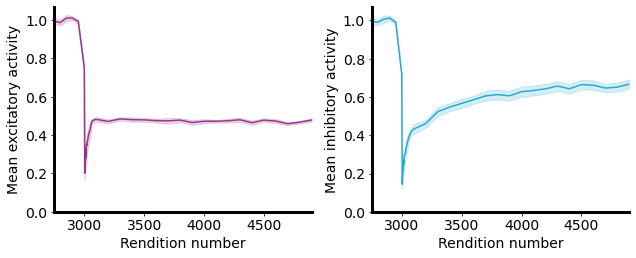

In [74]:
timepoints = np.concatenate([np.arange(2750, 3000, 50), np.arange(3000, 3020, 1), np.arange(3020, 3100, 10), np.arange(3100, 5000, 100)])

make_total_activity_plot([
    ['reduced_ie', 'DROP_SEV_0.5', 'firing_rate'],
],
    ['1', '2', '3'], color_sets, n_excs=[200, 200, 200], ylim1=None, ylim2=None,
    ylabel1=None, ylabel2=None, timepoints=timepoints, offsets=[2999, 2999, 2999], vertical_spacing=0.,
    tick_right=False, legend=True)

In [75]:
def extract_weight_dist_stats(names, recovered_exp_names, timepoints, n_exc=300, new_cell_idx=200):
    all_dirs = []
    for name in names:
        if type(names) is list:
            all_dirs.append([dirs for dirs in filter_list_by_name_frags(all_in_dir('./robustness'), name)])
        else:
            all_dirs.append([dirs for dirs in filter_list_by_name_frags(all_in_dir('./robustness'), [name])])
    
    all_weight_dist_info = []
    all_summed_weights = []
    
    for i, exp_dir_names in enumerate(all_dirs):
        
        summed_weights_for_group = [[] for t in timepoints]
        summed_weights_for_group_perturbed = [[] for t in timepoints]
        weight_freqs_for_group = [[] for t in timepoints]
        weight_bins = [[] for t in timepoints]
        
        for j, exp_dir_name in enumerate(exp_dir_names):
            if exp_dir_name not in recovered_exp_names:
                continue
            print(exp_dir_name)
            
            t_ctr = 0
            for k, data in load_exp_data(os.path.join('./robustness', exp_dir_name), timepoints, name_frags=[], n_exc=n_exc, new_cell_idx=new_cell_idx):
                summed_incoming_weights = data['summed_incoming_weights_e_e']
                summed_weights_for_group[t_ctr].append(summed_incoming_weights)
                
                bins, freqs = bin_occurrences(summed_incoming_weights, max_val=0.0035, bin_size=0.00001)
                weight_bins[t_ctr] = bins
                weight_freqs_for_group[t_ctr].append(freqs)
                
                t_ctr += 1
        
        mean_weight_dists = []
        std_weight_dists = []
        summed_weight_bins = []
        
        mean_summed_incoming_weights = []
        std_summed_incoming_weights = []
        all_summed_incoming_weights = []
        
        all_summed_incoming_weights_perturbed = []
        
        for i_t, t in enumerate(timepoints):
            mean_weight_dists.append(np.nanmean(weight_freqs_for_group[i_t], axis=0))
            std_weight_dists.append(np.nanstd(weight_freqs_for_group[i_t], axis=0))
            summed_weight_bins.append(weight_bins[i_t])
            
            summed_weights_for_group[i_t] = np.array(np.array(summed_weights_for_group[i_t]))
            all_summed_incoming_weights.append(np.concatenate(summed_weights_for_group[i_t]))
                
        all_weight_dist_info.append({
                'mean_weight_dists': mean_weight_dists,
                'std_weight_dists': std_weight_dists,
                'summed_weight_bins': summed_weight_bins[0],
                'all_summed_incoming_weights': all_summed_incoming_weights,
        })
    return all_weight_dist_info

In [50]:
all_weight_dist_info_1 = extract_weight_dist_stats([
    ['final', 'DROP_SEV_0.5', 'PER_SILENT_0.4', '2023-04-14'],
], recovered_exp_names, [2999, 3100, 6000], n_exc=200)

additive_SEED_4006_W_E_E_0.0012_W_E_I_3.5e-05_W_I_E_4e-05_DROP_SEV_0.4_COMP_MECH_secreted_regulation_CONDITION_no_repl_no_syn_PER_SILENT_0.4_A5_10_2023-04-09--01:03--01:5641
additive_SEED_4001_W_E_E_0.0012_W_E_I_3.5e-05_W_I_E_4e-05_DROP_SEV_0.4_COMP_MECH_secreted_regulation_CONDITION_no_repl_no_syn_PER_SILENT_0.4_A5_10_2023-04-09--01:04--12:3335
additive_SEED_4009_W_E_E_0.0012_W_E_I_3.5e-05_W_I_E_4e-05_DROP_SEV_0.4_COMP_MECH_secreted_regulation_CONDITION_no_repl_no_syn_PER_SILENT_0.4_A5_10_2023-04-09--01:04--10:3767
additive_SEED_4007_W_E_E_0.0012_W_E_I_3.5e-05_W_I_E_4e-05_DROP_SEV_0.4_COMP_MECH_secreted_regulation_CONDITION_no_repl_no_syn_PER_SILENT_0.4_A5_10_2023-04-09--01:03--01:0038
additive_SEED_4002_W_E_E_0.0012_W_E_I_3.5e-05_W_I_E_4e-05_DROP_SEV_0.4_COMP_MECH_secreted_regulation_CONDITION_no_repl_no_syn_PER_SILENT_0.4_A5_10_2023-04-09--01:04--12:4908
additive_SEED_4008_W_E_E_0.0012_W_E_I_3.5e-05_W_I_E_4e-05_DROP_SEV_0.4_COMP_MECH_secreted_regulation_CONDITION_no_repl_no_syn_PER_

<ipython-input-49-e5ab56f2346e>:50: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  summed_weights_for_group[i_t] = np.array(np.array(summed_weights_for_group[i_t]))


In [18]:
all_weight_dist_info_2 = extract_weight_dist_stats([
    ['additive', 'DROP_SEV_0.25', 'secreted_regulation', '2023-04-09'],
], recovered_exp_names, [1999, 2500, 7000], n_exc=200)

additive_SEED_4007_W_E_E_0.0012_W_E_I_3.5e-05_W_I_E_4e-05_DROP_SEV_0.25_COMP_MECH_secreted_regulation_CONDITION_no_repl_no_syn_PER_SILENT_0.4_A5_10_2023-04-09--01:03--01:0038
additive_SEED_4003_W_E_E_0.0012_W_E_I_3.5e-05_W_I_E_4e-05_DROP_SEV_0.25_COMP_MECH_secreted_regulation_CONDITION_no_repl_no_syn_PER_SILENT_0.4_A5_10_2023-04-09--01:03--46:5458
additive_SEED_4002_W_E_E_0.0012_W_E_I_3.5e-05_W_I_E_4e-05_DROP_SEV_0.25_COMP_MECH_secreted_regulation_CONDITION_no_repl_no_syn_PER_SILENT_0.4_A5_10_2023-04-09--01:04--12:4908
additive_SEED_4001_W_E_E_0.0012_W_E_I_3.5e-05_W_I_E_4e-05_DROP_SEV_0.25_COMP_MECH_secreted_regulation_CONDITION_no_repl_no_syn_PER_SILENT_0.4_A5_10_2023-04-09--01:03--09:3335
additive_SEED_4004_W_E_E_0.0012_W_E_I_3.5e-05_W_I_E_4e-05_DROP_SEV_0.25_COMP_MECH_secreted_regulation_CONDITION_no_repl_no_syn_PER_SILENT_0.4_A5_10_2023-04-09--01:03--46:1486
additive_SEED_4000_W_E_E_0.0012_W_E_I_3.5e-05_W_I_E_4e-05_DROP_SEV_0.25_COMP_MECH_secreted_regulation_CONDITION_no_repl_no_sy

<ipython-input-17-e5ab56f2346e>:50: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  summed_weights_for_group[i_t] = np.array(np.array(summed_weights_for_group[i_t]))


In [21]:
all_weight_dist_info_3 = extract_weight_dist_stats([
    ['additive', 'DROP_SEV_0.1', 'secreted_regulation', '2023-04-09'],
], recovered_exp_names, [1999, 2500, 7000], n_exc=200)

additive_SEED_4005_W_E_E_0.0012_W_E_I_3.5e-05_W_I_E_4e-05_DROP_SEV_0.1_COMP_MECH_secreted_regulation_CONDITION_no_repl_no_syn_PER_SILENT_0.4_A5_10_2023-04-09--01:03--46:7349
additive_SEED_4007_W_E_E_0.0012_W_E_I_3.5e-05_W_I_E_4e-05_DROP_SEV_0.1_COMP_MECH_secreted_regulation_CONDITION_no_repl_no_syn_PER_SILENT_0.4_A5_10_2023-04-09--01:03--01:0038
additive_SEED_4002_W_E_E_0.0012_W_E_I_3.5e-05_W_I_E_4e-05_DROP_SEV_0.1_COMP_MECH_secreted_regulation_CONDITION_no_repl_no_syn_PER_SILENT_0.4_A5_10_2023-04-09--01:04--12:4908
additive_SEED_4009_W_E_E_0.0012_W_E_I_3.5e-05_W_I_E_4e-05_DROP_SEV_0.1_COMP_MECH_secreted_regulation_CONDITION_no_repl_no_syn_PER_SILENT_0.4_A5_10_2023-04-09--01:03--09:3767
additive_SEED_4000_W_E_E_0.0012_W_E_I_3.5e-05_W_I_E_4e-05_DROP_SEV_0.1_COMP_MECH_secreted_regulation_CONDITION_no_repl_no_syn_PER_SILENT_0.4_A5_10_2023-04-09--01:03--09:6587
additive_SEED_4006_W_E_E_0.0012_W_E_I_3.5e-05_W_I_E_4e-05_DROP_SEV_0.1_COMP_MECH_secreted_regulation_CONDITION_no_repl_no_syn_PER_

<ipython-input-17-e5ab56f2346e>:50: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  summed_weights_for_group[i_t] = np.array(np.array(summed_weights_for_group[i_t]))


In [19]:
def make_interpolated_violin_plot_and_weight_traj(all_weight_dist_info, names, dist_timepoints, n_excs=[300], new_cell_idx=200, exc_cell_color='black', inh_cell_color='blue', ylim=(0, 1), ylim2=(0, 1)):
    scale = 1.3
    fig, axs = plt.subplots(1, 2, sharex=False, sharey=False, figsize=(8 * scale, 4 * scale))
    plt.locator_params(axis='x', nbins=6)

    dist_timepoints = np.array(dist_timepoints)
    colors = get_equally_spaced_colors(3, cmap='winter')

    for k, dist_data_for_name in enumerate(all_weight_dist_info):
        if len(dist_data_for_name) > 0:
            axs[1].set_ylabel('Summed synaptic strength')
            axs[1].yaxis.set_label_position('right')
            axs[1].yaxis.tick_right()
            axs[0].set_ylim(ylim2)
            axs[1].set_ylim(ylim)
            
            axs[0].xaxis.set_major_locator(plt.MaxNLocator(5))
                        
            widths = 0.9
            
            mean_initial_summed_incoming_weight = np.mean(dist_data_for_name['all_summed_incoming_weights'][0])
            normalized_data = dist_data_for_name['all_summed_incoming_weights'] / mean_initial_summed_incoming_weight
            
            parts = axs[1].violinplot(normalized_data, positions= 1 + np.arange(len(normalized_data)), showmeans=False, showextrema=False, widths=widths)
            for pc in parts['bodies']:
                pc.set_facecolor(exc_cell_color)
    #             pc.set_edgecolor('black')
                pc.set_alpha(0.15)

            num_to_sample = 100
            for i, dist_data in enumerate(dist_data_for_name['all_summed_incoming_weights']):
                indices_to_show = np.arange(len(normalized_data[i]))
                np.random.shuffle(indices_to_show)
                indices_to_show = indices_to_show[:num_to_sample]
                
                axs[1].scatter(i + 1 + np.random.normal(size=num_to_sample, scale=0.05), normalized_data[i][indices_to_show],
                            s=10, color=exc_cell_color, zorder=3)
            axs[1].set_xticks([1, 2, 3])
            axs[1].set_xticklabels([
                'Initial',
                r'$1200^{th}$' + '\nrendition',
                r'$2500^{th}$'  + '\nrendition'
            ])
            axs[1].set_ylabel('Normalized summed \nsynaptic strength')
        
            axs[0].spines['top'].set_visible(False)
            axs[0].spines['right'].set_visible(False)
            axs[1].spines['top'].set_visible(False)
            axs[1].spines['left'].set_visible(False)
        
#             axs[0].tick_params(right=True, labelright=True)

            timepoints_start = dist_timepoints[0] - 100 if dist_timepoints[0] - 10 > 0 else 0
            timepoints = np.arange(timepoints_start, dist_timepoints[-1] + 100, 100)

            make_figure_2_plot(names, labels=['', '', ''],
            condition_colors=color_sets[1:], timepoints=timepoints, offsets=dist_timepoints[0] * np.ones(20), vertical_spacing=0.,
            file_name_ext='', axs=[axs[0], axs[0]], fig=fig, tick_right=False, legend=False, ylabel2='Normalized summed \nsynapse strength', n_excs=n_excs)
            set_font_size(axs[0], 14)
            set_font_size(axs[1], 14)
            
            save_fig(fig, './figures/paper/weight_trajectories', f'{k}.svg')

<ipython-input-51-87d0b431afe1>:22: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  normalized_data = dist_data_for_name['all_summed_incoming_weights'] / mean_initial_summed_incoming_weight


['additive', 'DROP_SEV_0.4', 'secreted_regulation', '2023-04-09']
additive_SEED_4006_W_E_E_0.0012_W_E_I_3.5e-05_W_I_E_4e-05_DROP_SEV_0.4_COMP_MECH_secreted_regulation_CONDITION_no_repl_no_syn_PER_SILENT_0.4_A5_10_2023-04-09--01:03--01:5641
additive_SEED_4001_W_E_E_0.0012_W_E_I_3.5e-05_W_I_E_4e-05_DROP_SEV_0.4_COMP_MECH_secreted_regulation_CONDITION_no_repl_no_syn_PER_SILENT_0.4_A5_10_2023-04-09--01:04--12:3335
additive_SEED_4009_W_E_E_0.0012_W_E_I_3.5e-05_W_I_E_4e-05_DROP_SEV_0.4_COMP_MECH_secreted_regulation_CONDITION_no_repl_no_syn_PER_SILENT_0.4_A5_10_2023-04-09--01:04--10:3767
additive_SEED_4007_W_E_E_0.0012_W_E_I_3.5e-05_W_I_E_4e-05_DROP_SEV_0.4_COMP_MECH_secreted_regulation_CONDITION_no_repl_no_syn_PER_SILENT_0.4_A5_10_2023-04-09--01:03--01:0038
additive_SEED_4002_W_E_E_0.0012_W_E_I_3.5e-05_W_I_E_4e-05_DROP_SEV_0.4_COMP_MECH_secreted_regulation_CONDITION_no_repl_no_syn_PER_SILENT_0.4_A5_10_2023-04-09--01:04--12:4908
additive_SEED_4008_W_E_E_0.0012_W_E_I_3.5e-05_W_I_E_4e-05_DROP_S

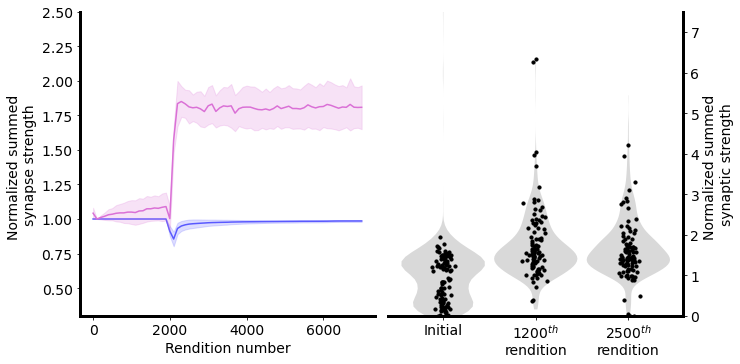

In [53]:
make_interpolated_violin_plot_and_weight_traj(all_weight_dist_info_1, [
    ['additive', 'DROP_SEV_0.4', 'secreted_regulation', '2023-04-09'],
], dist_timepoints=[100, 2500, 7000], n_excs=[200, 200, 200], ylim=(0, 7.5), ylim2=(0.3, 2.5))


<ipython-input-19-87d0b431afe1>:22: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  normalized_data = dist_data_for_name['all_summed_incoming_weights'] / mean_initial_summed_incoming_weight


['additive', 'DROP_SEV_0.25', 'secreted_regulation', '2023-04-09']
additive_SEED_4007_W_E_E_0.0012_W_E_I_3.5e-05_W_I_E_4e-05_DROP_SEV_0.25_COMP_MECH_secreted_regulation_CONDITION_no_repl_no_syn_PER_SILENT_0.4_A5_10_2023-04-09--01:03--01:0038
additive_SEED_4003_W_E_E_0.0012_W_E_I_3.5e-05_W_I_E_4e-05_DROP_SEV_0.25_COMP_MECH_secreted_regulation_CONDITION_no_repl_no_syn_PER_SILENT_0.4_A5_10_2023-04-09--01:03--46:5458
additive_SEED_4002_W_E_E_0.0012_W_E_I_3.5e-05_W_I_E_4e-05_DROP_SEV_0.25_COMP_MECH_secreted_regulation_CONDITION_no_repl_no_syn_PER_SILENT_0.4_A5_10_2023-04-09--01:04--12:4908
additive_SEED_4001_W_E_E_0.0012_W_E_I_3.5e-05_W_I_E_4e-05_DROP_SEV_0.25_COMP_MECH_secreted_regulation_CONDITION_no_repl_no_syn_PER_SILENT_0.4_A5_10_2023-04-09--01:03--09:3335
additive_SEED_4004_W_E_E_0.0012_W_E_I_3.5e-05_W_I_E_4e-05_DROP_SEV_0.25_COMP_MECH_secreted_regulation_CONDITION_no_repl_no_syn_PER_SILENT_0.4_A5_10_2023-04-09--01:03--46:1486
additive_SEED_4000_W_E_E_0.0012_W_E_I_3.5e-05_W_I_E_4e-05_

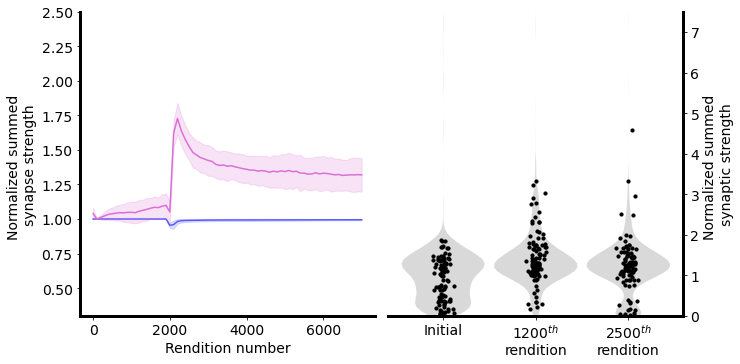

In [20]:
make_interpolated_violin_plot_and_weight_traj(all_weight_dist_info_2, [
    ['additive', 'DROP_SEV_0.25', 'secreted_regulation', '2023-04-09'],
], dist_timepoints=[100, 2500, 7000], n_excs=[200, 200, 200], ylim=(0, 7.5), ylim2=(0.3, 2.5))


<ipython-input-19-87d0b431afe1>:22: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  normalized_data = dist_data_for_name['all_summed_incoming_weights'] / mean_initial_summed_incoming_weight


['additive', 'DROP_SEV_0.1', 'secreted_regulation', '2023-04-09']
additive_SEED_4005_W_E_E_0.0012_W_E_I_3.5e-05_W_I_E_4e-05_DROP_SEV_0.1_COMP_MECH_secreted_regulation_CONDITION_no_repl_no_syn_PER_SILENT_0.4_A5_10_2023-04-09--01:03--46:7349
additive_SEED_4007_W_E_E_0.0012_W_E_I_3.5e-05_W_I_E_4e-05_DROP_SEV_0.1_COMP_MECH_secreted_regulation_CONDITION_no_repl_no_syn_PER_SILENT_0.4_A5_10_2023-04-09--01:03--01:0038
additive_SEED_4002_W_E_E_0.0012_W_E_I_3.5e-05_W_I_E_4e-05_DROP_SEV_0.1_COMP_MECH_secreted_regulation_CONDITION_no_repl_no_syn_PER_SILENT_0.4_A5_10_2023-04-09--01:04--12:4908
additive_SEED_4009_W_E_E_0.0012_W_E_I_3.5e-05_W_I_E_4e-05_DROP_SEV_0.1_COMP_MECH_secreted_regulation_CONDITION_no_repl_no_syn_PER_SILENT_0.4_A5_10_2023-04-09--01:03--09:3767
additive_SEED_4000_W_E_E_0.0012_W_E_I_3.5e-05_W_I_E_4e-05_DROP_SEV_0.1_COMP_MECH_secreted_regulation_CONDITION_no_repl_no_syn_PER_SILENT_0.4_A5_10_2023-04-09--01:03--09:6587
additive_SEED_4006_W_E_E_0.0012_W_E_I_3.5e-05_W_I_E_4e-05_DROP_S

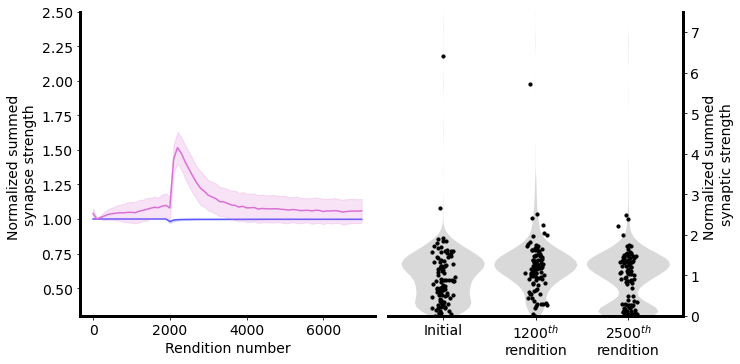

In [24]:
make_interpolated_violin_plot_and_weight_traj(all_weight_dist_info_3, [
    ['additive', 'DROP_SEV_0.1', 'secreted_regulation', '2023-04-09'],
], dist_timepoints=[100, 2500, 7000], n_excs=[200, 200, 200], ylim=(0, 7.5), ylim2=(0.3, 2.5))


In [76]:
def calc_rowwise_entropy(mat):
    return np.sum(np.where(mat > 0, -np.log(mat) * mat, 0), axis=1)

def make_weight_evolution_plot(names, n_excs=200, file_name_ext='', ylim1=None, ylim2=None,
                       ylabel1=None, ylabel2=None, timepoints_pre=[], timepoints_post=[], offsets=[], vertical_spacing=0.,
                       axs=None, fig=None, tick_right=True, legend=True):
    scale = 1.6
    
    if fig is None:
        fig, axs = plt.subplots(1, 2, sharex=True, sharey=False, figsize=(6 * scale, 2.5 * scale))
    
    all_dirs = []
    for name in names:
        if type(name) is not list:
            name = [name]
        print(name)
        all_dirs.append([dirs for dirs in filter_list_by_name_frags(all_in_dir('./robustness'), name)])
        
    timepoints_pre = np.array(timepoints_pre)
    timepoints_post = np.array(timepoints_post)
        
    for idx, exp_dir_names in enumerate(all_dirs):
        count = 0
        
        if type(n_excs) is list:
            n_exc = n_excs[idx]
        else:
            n_exc = n_excs
            
        all_initially_active_summed_in_means = []
        all_initially_silent_summed_in_means = []
        all_initially_active_avg_entropies = []
        all_initially_silent_avg_entropies = []
        
        
        for j, exp_dir_name in enumerate(exp_dir_names):
            if exp_dir_name not in recovered_exp_names:
                continue
                
            initially_active_mask = np.zeros(n_exc).astype(bool)
#             if count >= 2:
#                 continue
            count += 1

            print(exp_dir_name)

            initially_active_summed_in_means = []
            initially_silent_summed_in_means = []
            initially_active_avg_entropies = []
            initially_silent_avg_entropies = []

            for i, data in load_exp_data(os.path.join('./robustness', exp_dir_name), np.concatenate([timepoints_pre, timepoints_post]), n_exc=n_exc, name_frags=[], new_cell_idx=200):
    
                w_r_e_e = data['w_r_e'][:n_exc, :n_exc]
                if i in timepoints_pre:
                    initially_active_mask = np.logical_or(initially_active_mask, ~np.isnan(data['first_spk_times']))
                    
                if i in timepoints_post:
                    w_r_e_e = data['w_r_e'][:n_exc, :n_exc]
                        
                    if 'surviving_cell_mask' not in data:
                        w_r_e_e_initially_active = w_r_e_e[initially_active_mask, :]
                        w_r_e_e_initially_silent = w_r_e_e[~initially_active_mask, :]
                    else:
                        surviving_cell_mask = data['surviving_cell_mask']
                        w_r_e_e_initially_active = w_r_e_e[np.logical_and(initially_active_mask, surviving_cell_mask), :]
                        w_r_e_e_initially_silent = w_r_e_e[np.logical_and(~initially_active_mask, surviving_cell_mask), :]
                    
                    initially_active_summed_in = np.sum(w_r_e_e_initially_active, axis=1)
                    initially_silent_summed_in = np.sum(w_r_e_e_initially_silent, axis=1)
                    
                    initially_active_summed_in_mean = np.mean(initially_active_summed_in)
                    initially_silent_summed_in_mean = np.mean(initially_silent_summed_in)
                    
                    w_r_e_e_initially_active_normed = w_r_e_e_initially_active / initially_active_summed_in.reshape(initially_active_summed_in.shape[0], 1)
                    w_r_e_e_initially_silent_normed = w_r_e_e_initially_silent / initially_silent_summed_in.reshape(initially_silent_summed_in.shape[0], 1)
                                    
                    initially_active_avg_entropy = np.mean(calc_rowwise_entropy(w_r_e_e_initially_active_normed))
                    initially_silent_avg_entropy = np.mean(calc_rowwise_entropy(w_r_e_e_initially_silent_normed))
                    
                    initially_active_summed_in_means.append(initially_active_summed_in_mean)
                    initially_silent_summed_in_means.append(initially_silent_summed_in_mean)
                    
                    initially_active_avg_entropies.append(initially_active_avg_entropy)
                    initially_silent_avg_entropies.append(initially_silent_avg_entropy)
                    
            print('start')
            print(np.any(np.isnan(np.array(initially_active_summed_in_means))))
            print(np.any(np.isnan(np.array(initially_silent_summed_in_means))))
            
            initially_active_summed_in_means = np.array(initially_active_summed_in_means)
            normed_initially_active_summed_in_means = initially_active_summed_in_means / np.mean(np.array(initially_active_summed_in_means)[:5])
            initially_silent_summed_in_means = np.array(initially_silent_summed_in_means)
            normed_initially_silent_summed_in_means = initially_silent_summed_in_means / np.mean(np.array(initially_active_summed_in_means)[:5])
            
            axs[0].plot(timepoints_post, normed_initially_active_summed_in_means, c='black', lw=1, alpha=0.2)
            axs[0].plot(timepoints_post, normed_initially_silent_summed_in_means, c='red', lw=1, alpha=0.2)
                    
            initially_active_avg_entropies = np.array(initially_active_avg_entropies)
            normed_initially_active_avg_entropies = initially_active_avg_entropies / np.mean(initially_active_avg_entropies[:5])
            initially_silent_avg_entropies = np.array(initially_silent_avg_entropies)
            normed_initially_silent_avg_entropies = initially_silent_avg_entropies / np.mean(initially_silent_avg_entropies[:5])
                
            axs[1].plot(timepoints_post, normed_initially_active_avg_entropies, c='black', lw=1, alpha=0.2)
            axs[1].plot(timepoints_post, normed_initially_silent_avg_entropies, c='red', lw=1, alpha=0.2)
            
            all_initially_active_summed_in_means.append(normed_initially_active_summed_in_means)
            all_initially_silent_summed_in_means.append(normed_initially_silent_summed_in_means)
            all_initially_active_avg_entropies.append(normed_initially_active_avg_entropies)
            all_initially_silent_avg_entropies.append(normed_initially_silent_avg_entropies)
            
        axs[0].plot(timepoints_post, np.mean(np.stack(all_initially_active_summed_in_means), axis=0), c='black', lw=2.5)
        axs[0].plot(timepoints_post, np.mean(np.stack(all_initially_silent_summed_in_means), axis=0), c='red', lw=2.5)
        axs[1].plot(timepoints_post, np.mean(np.stack(all_initially_active_avg_entropies), axis=0), c='black', lw=2.5)
        axs[1].plot(timepoints_post, np.mean(np.stack(all_initially_silent_avg_entropies), axis=0), c='red', lw=2.5)
            
        for i in range(2):
            axs[i].spines['right'].set_visible(False)
            axs[i].spines['top'].set_visible(False)
            plt.locator_params(axis='x', nbins=5)
            plt.locator_params(axis='y', nbins=3)
            set_font_size(axs[i], 15)
        
        fig.tight_layout()
        
        axs[0].set_ylim(0)
        axs[0].set_xlabel('Renditions')
        axs[0].set_ylabel('Summed synaptic strength')
    
        axs[1].set_xlabel('Renditions')
        axs[1].set_ylabel('Entropy of afferent synapses')
    fig.tight_layout()
    save_fig(fig, './figures/paper/weight_evo', f'{file_name_ext}.png')
    save_fig(fig, './figures/paper/weight_evo', f'{file_name_ext}.svg')

['reduced_ie', 'DROP_SEV_0.5', 'secreted_regulation']
reduced_ie_SEED_7005_W_E_E_0.0004_W_E_I_3.5e-05_W_I_E_4e-05_DROP_SEV_0.5_COMP_MECH_secreted_regulation_CONDITION_no_repl_no_syn_PER_SILENT_0.4_A5_5_2023-04-24--23:08--46:7060
start
False
False
reduced_ie_SEED_7008_W_E_E_0.0004_W_E_I_3.5e-05_W_I_E_4e-05_DROP_SEV_0.5_COMP_MECH_secreted_regulation_CONDITION_no_repl_no_syn_PER_SILENT_0.4_A5_5_2023-04-24--23:08--46:3797
start
False
False
reduced_ie_SEED_7007_W_E_E_0.0004_W_E_I_3.5e-05_W_I_E_4e-05_DROP_SEV_0.5_COMP_MECH_secreted_regulation_CONDITION_no_repl_no_syn_PER_SILENT_0.4_A5_5_2023-04-24--23:08--46:9962
start
False
False
reduced_ie_SEED_7004_W_E_E_0.0004_W_E_I_3.5e-05_W_I_E_4e-05_DROP_SEV_0.5_COMP_MECH_secreted_regulation_CONDITION_no_repl_no_syn_PER_SILENT_0.4_A5_5_2023-04-24--23:08--43:7863
start
False
False
reduced_ie_SEED_7000_W_E_E_0.0004_W_E_I_3.5e-05_W_I_E_4e-05_DROP_SEV_0.5_COMP_MECH_secreted_regulation_CONDITION_no_repl_no_syn_PER_SILENT_0.4_A5_5_2023-04-24--23:08--43:0552

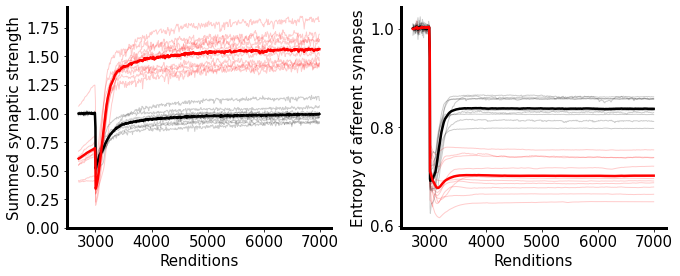

In [77]:
make_weight_evolution_plot([
    ['reduced_ie', 'DROP_SEV_0.5', 'secreted_regulation'],
], timepoints_pre=np.arange(2650, 2700), timepoints_post=np.concatenate([np.arange(2700, 3000, 10), np.arange(3000, 3010), np.arange(3010, 7000, 10)]),
file_name_ext='drop_0.5')

In [19]:
def get_ordered_colors(cmap, n, lb=0, ub=1):
    cmap = cm.get_cmap(cmap)
    return cmap(np.linspace(lb, ub, n))

In [34]:
def sliding_window_activity(raster, window_size, dt, interval):
    window_size_discrete = int(window_size / dt)
    all_spk_times = np.sort(raster[0, :])
    all_t = np.arange(interval[0], interval[1], dt)
    activity = np.zeros(all_t.shape)
    
    for i_t, t in enumerate(all_t):
        window_start = bisect_left(all_spk_times, t - window_size)
        window_end = bisect_left(all_spk_times, t + window_size)
        activity[i_t] = len(all_spk_times[window_start:window_end])
    return all_t, activity

def find_sequence_end(trace, t):
    t_ctr = len(trace) - 1
    while trace[t_ctr] == 0:
        t_ctr -= 1
    return t[t_ctr + 1]

def find_sequence_beginning(trace, t):
    t_ctr = 0
    while trace[t_ctr] == 0:
        t_ctr += 1
    return t[t_ctr - 1]

def find_seq_duration(trace, t):
#     print(find_sequence_end(trace, t))
#     print(find_sequence_beginning(trace, t))
    return find_sequence_end(trace, t) - find_sequence_beginning(trace, t)

def make_duration_graphs(name, timepoints=[0, 72, 73], n_exc=450, new_cell_idx=None):
    if type(name) is list:
        all_dirs = filter_list_by_name_frags(all_in_dir('./robustness'), name)
    else:
        all_dirs = filter_list_by_name_frags(all_in_dir('./robustness'), [name])
       
    scale = 0.8
    n_plots = 1
    fig = plt.figure(constrained_layout=True, figsize=(7 * scale, 5 * n_plots * scale))
    gs = gridspec.GridSpec(ncols=1, nrows=1, figure=fig)
    axs = [fig.add_subplot(gs[i]) for i in range(n_plots)]
    
    colors = get_ordered_colors('gist_ncar', 30)
    
    for d_idx, exp_dir_name in enumerate(sorted(all_dirs)):
        if exp_dir_name not in recovered_exp_names:
            continue
        
        old_activity_durations = []
        total_activity_durations = []
        
#         if d_idx > 10:
#             continue

        for i, data in load_exp_data(os.path.join('./robustness', exp_dir_name), timepoints, reverse=False, n_exc=n_exc, new_cell_idx=new_cell_idx):
            exc_raster = data['exc_raster_unperturbed']

            exc_raster_old = exc_raster[:, exc_raster[1, :] < new_cell_idx]
            exc_raster_new = exc_raster[:, exc_raster[1, :] >= new_cell_idx]

            inh_raster = data['inh_raster']

            t, e_old_activity_trace = sliding_window_activity(exc_raster_old, 3e-3, dt, (0, 0.14))
            t, e_new_activity_trace = sliding_window_activity(exc_raster_new, 3e-3, dt, (0, 0.14))
            t, e_activity_trace = sliding_window_activity(np.concatenate([exc_raster_old, exc_raster_new], axis=1), 3e-3, dt, (0, 0.14))
            t, i_activity_trace = sliding_window_activity(inh_raster, 3e-3, dt, (0, 0.14))

            t = 1000 * t

            e_old_duration = find_seq_duration(e_old_activity_trace, t)
            e_total_duration = find_seq_duration(e_activity_trace, t)

            old_activity_durations.append(e_old_duration)
            total_activity_durations.append(e_total_duration)
        
        total_activity_durations = np.array(total_activity_durations)
#         axs[0].plot(timepoints[:len(old_activity_durations)], old_activity_durations, lw=0.5, c='black')
        def norm(arr):
            return (arr - arr.min()) / (arr.max() - arr.min())

        axs[0].scatter(timepoints[:len(total_activity_durations)], 100 * total_activity_durations / np.mean(total_activity_durations[:10]), s=2, color=colors[d_idx])
        
    axs[0].set_ylabel('Activation duration')
    axs[0].set_xlabel('Rendition No.')
    axs[0].spines['right'].set_visible(False)
    axs[0].spines['top'].set_visible(False)
    axs[0].set_xlim(timepoints[0], timepoints[-1])
    set_font_size(axs[0], 14)
    plt.locator_params(axis='y', nbins=6)
    axs[0].yaxis.set_major_formatter(mtick.PercentFormatter())

/var/folders/rp/n8h2l6w51774kxnq18z19s8r0000gn/T/ipykernel_19408/402873183.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap)


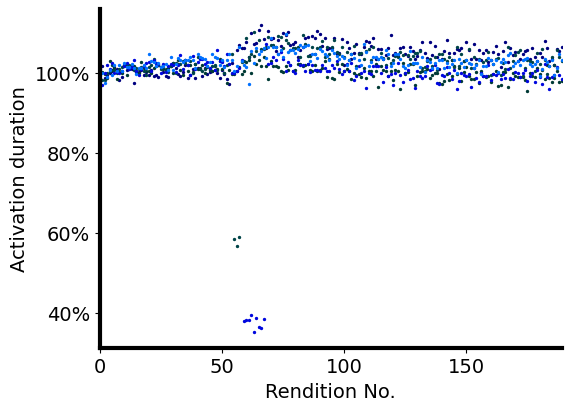

In [36]:
make_duration_graphs(['gradual_dropout'],
                           timepoints=np.arange(0, 190), n_exc=200, new_cell_idx=200)

In [31]:
def make_duration_dist_graphs(name, timepoints=[0, 72, 73], n_exc=450, new_cell_idx=None, rendition_batch_size=50):
    if type(name) is list:
        all_dirs = filter_list_by_name_frags(all_in_dir('./robustness'), name)
    else:
        all_dirs = filter_list_by_name_frags(all_in_dir('./robustness'), [name])
       
    scale = 2
    n_plots = int(np.ceil((timepoints[-1] - timepoints[0]) / rendition_batch_size))
    
    colors = get_ordered_colors('gist_ncar', 30)
    
    for d_idx, exp_dir_name in enumerate(sorted(all_dirs)):
        if exp_dir_name not in recovered_exp_names:
            continue
            
        fig, axs = plt.subplots(n_plots, 1, sharex=True, sharey=True, figsize=(3 * scale, 3  * scale))

        old_activity_durations = []
        total_activity_durations = []

        for i, data in load_exp_data(os.path.join('./robustness', exp_dir_name), timepoints, reverse=False, n_exc=n_exc, new_cell_idx=new_cell_idx):
            exc_raster = data['exc_raster_unperturbed']

            exc_raster_old = exc_raster[:, exc_raster[1, :] < new_cell_idx]
            exc_raster_new = exc_raster[:, exc_raster[1, :] >= new_cell_idx]

            inh_raster = data['inh_raster']

            t, e_old_activity_trace = sliding_window_activity(exc_raster_old, 3e-3, dt, (0, 0.14))
            t, e_new_activity_trace = sliding_window_activity(exc_raster_new, 3e-3, dt, (0, 0.14))
            t, e_activity_trace = sliding_window_activity(np.concatenate([exc_raster_old, exc_raster_new], axis=1), 3e-3, dt, (0, 0.14))
            t, i_activity_trace = sliding_window_activity(inh_raster, 3e-3, dt, (0, 0.14))

            t = 1000 * t

            e_old_duration = find_seq_duration(e_old_activity_trace, t)
            e_total_duration = find_seq_duration(e_activity_trace, t)

            old_activity_durations.append(e_old_duration)
            total_activity_durations.append(e_total_duration)
        
        total_activity_durations = np.array(total_activity_durations)
        for l in np.arange(0, timepoints[-1] - timepoints[0], rendition_batch_size):
            batch_durations = total_activity_durations[l:l+rendition_batch_size]
            axs[int(l/rendition_batch_size)].hist(batch_durations, bins=25, range=(0, 100), color=color_sets[2][0])
            axs[int(l/rendition_batch_size)].spines['right'].set_visible(False)
            axs[int(l/rendition_batch_size)].spines['top'].set_visible(False)
            set_font_size(axs[int(l/rendition_batch_size)], 14)
        
        axs[-1].set_xlabel('Duration (ms)')
        axs[0].set_ylabel('Counts')
        plt.locator_params(axis='y', nbins=2)
        fig.tight_layout()
        

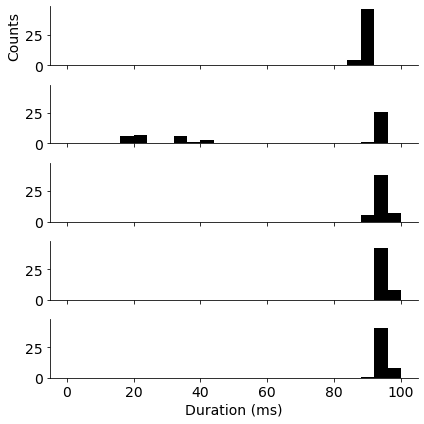

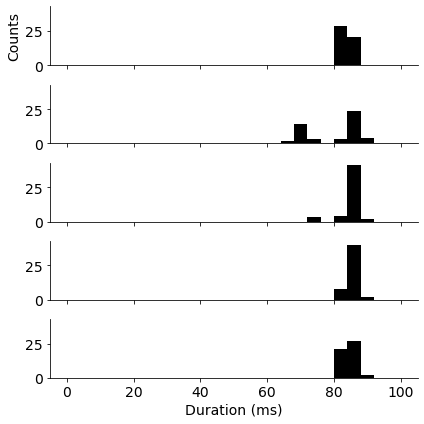

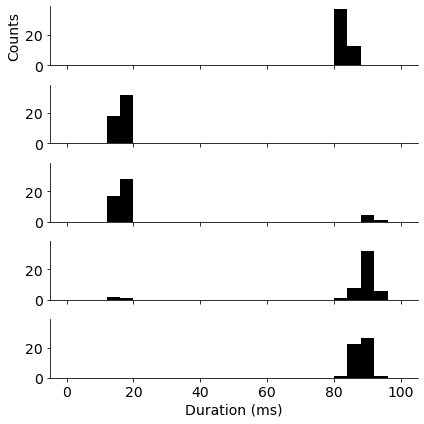

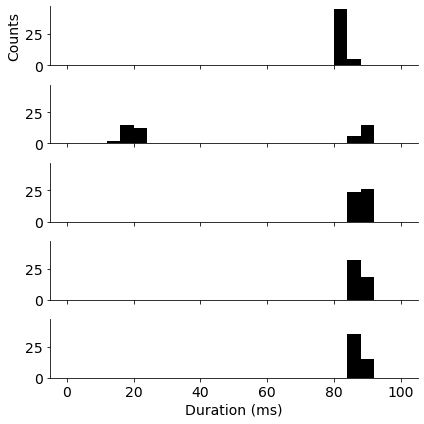

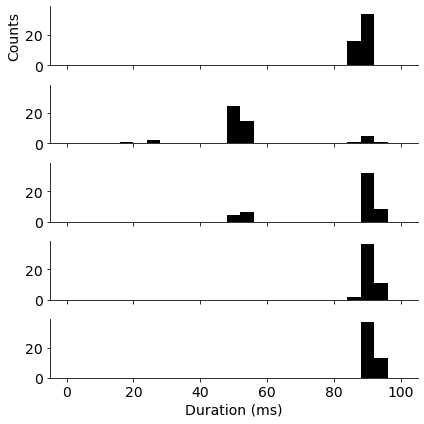

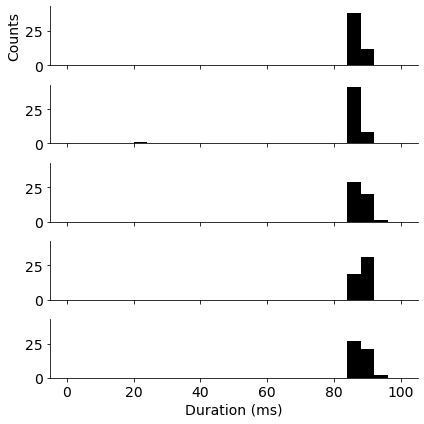

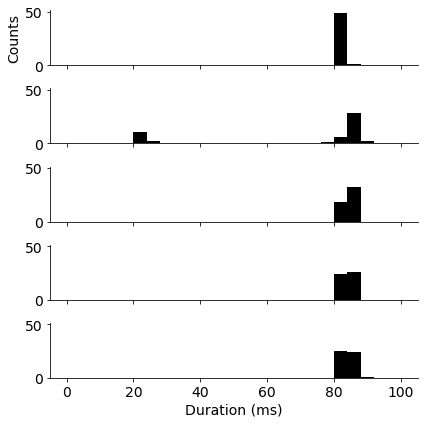

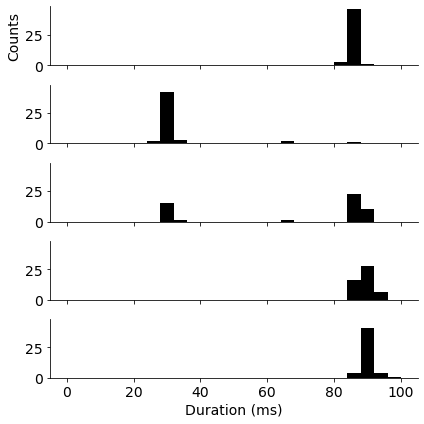

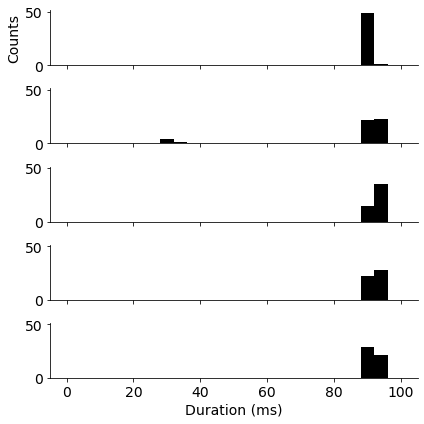

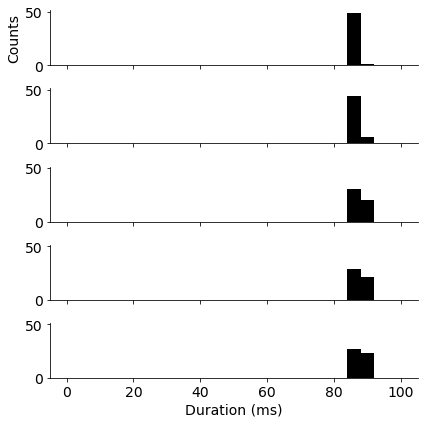

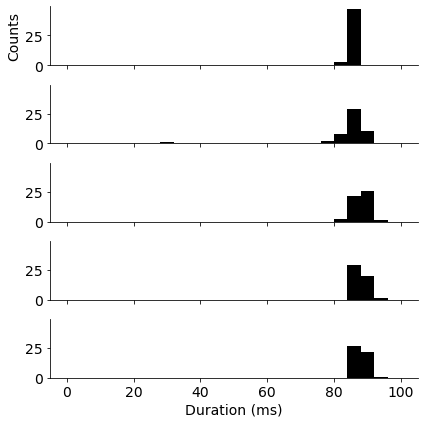

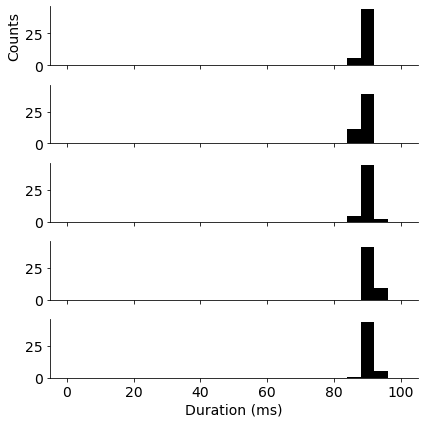

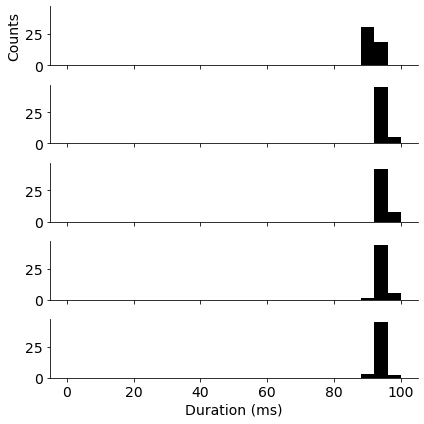

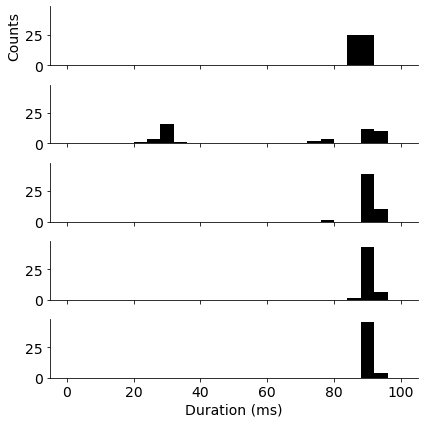

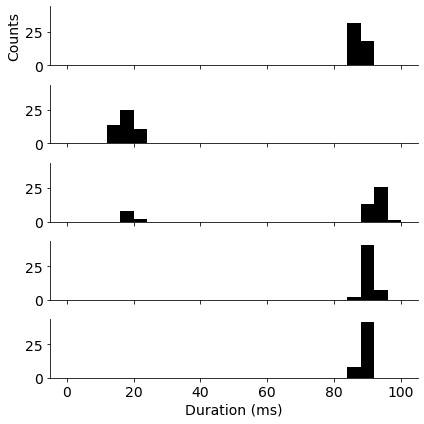

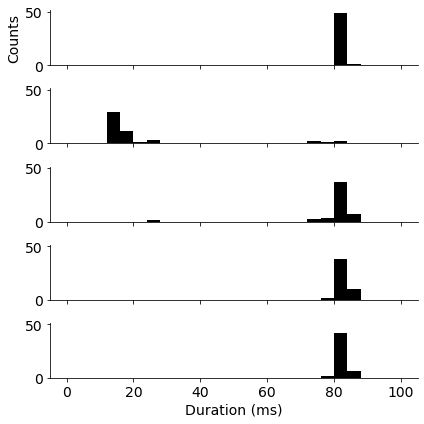

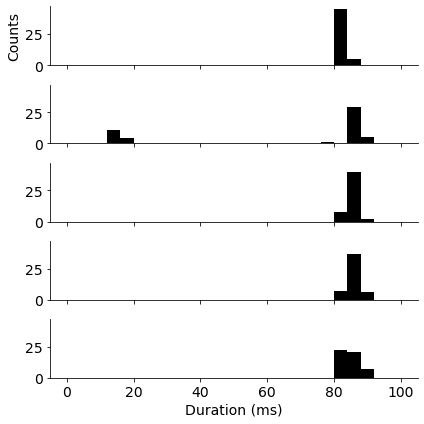

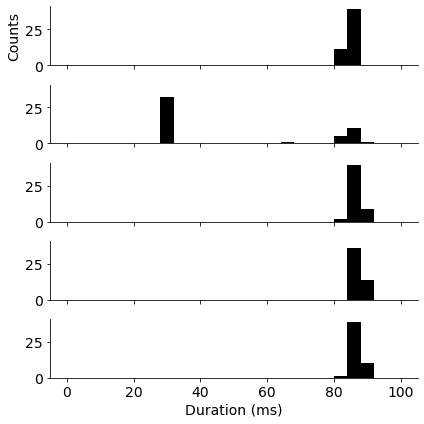

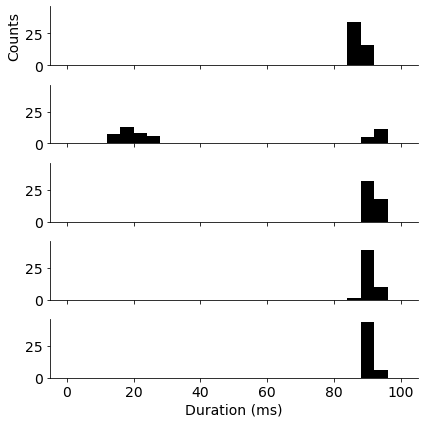

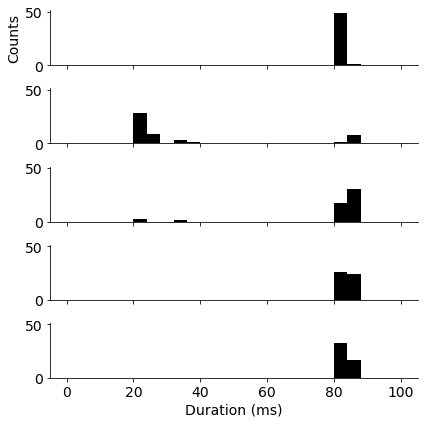

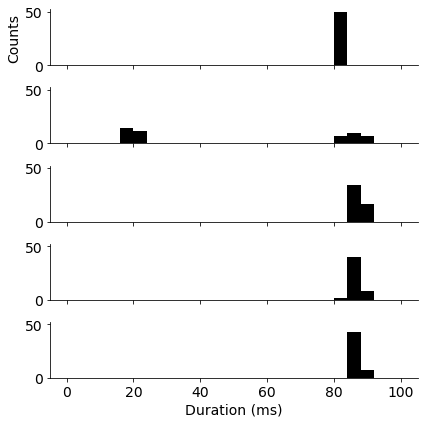

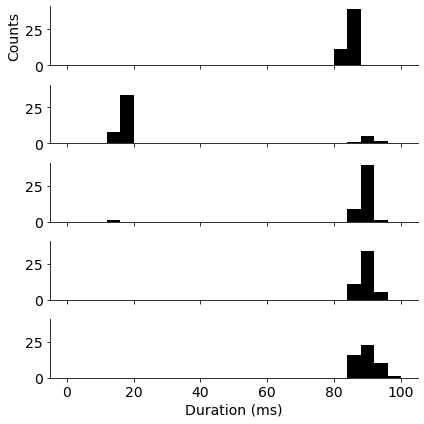

In [53]:
make_duration_dist_graphs(['DROP_SEV_0.5', 'secreted_regulation', 'A5_0.5'],
                           timepoints=np.arange(950, 1200), n_exc=200, new_cell_idx=200)

In [44]:
def make_duration_mode_graphs(name, timepoints=[0, 72, 73], n_exc=450, new_cell_idx=None, rendition_batch_size=3):
    if type(name) is list:
        all_dirs = filter_list_by_name_frags(all_in_dir('./robustness'), name)
    else:
        all_dirs = filter_list_by_name_frags(all_in_dir('./robustness'), [name])
    
    colors = get_ordered_colors('gist_ncar', 30)
    
    scale = 0.8
    n_plots = 1
    fig = plt.figure(constrained_layout=True, figsize=(7 * scale, 5 * n_plots * scale))
    gs = gridspec.GridSpec(ncols=1, nrows=1, figure=fig)
    axs = [fig.add_subplot(gs[i]) for i in range(n_plots)]
    
    for d_idx, exp_dir_name in enumerate(sorted(all_dirs)):
        if exp_dir_name not in recovered_exp_names:
            continue
            
        old_activity_durations = []
        total_activity_durations = []

        for i, data in load_exp_data(os.path.join('./robustness', exp_dir_name), timepoints, reverse=False, n_exc=n_exc, new_cell_idx=new_cell_idx):
            exc_raster = data['exc_raster_unperturbed']

            exc_raster_old = exc_raster[:, exc_raster[1, :] < new_cell_idx]
            exc_raster_new = exc_raster[:, exc_raster[1, :] >= new_cell_idx]

            inh_raster = data['inh_raster']

            t, e_old_activity_trace = sliding_window_activity(exc_raster_old, 3e-3, dt, (0, 0.14))
            t, e_new_activity_trace = sliding_window_activity(exc_raster_new, 3e-3, dt, (0, 0.14))
            t, e_activity_trace = sliding_window_activity(np.concatenate([exc_raster_old, exc_raster_new], axis=1), 3e-3, dt, (0, 0.14))
            t, i_activity_trace = sliding_window_activity(inh_raster, 3e-3, dt, (0, 0.14))

            t = 1000 * t

            e_old_duration = find_seq_duration(e_old_activity_trace, t)
            e_total_duration = find_seq_duration(e_activity_trace, t)

            old_activity_durations.append(e_old_duration)
            total_activity_durations.append(e_total_duration)
        
        all_modes = []
        
        total_activity_durations = np.array(total_activity_durations)
        for l in np.arange(0, timepoints[-1] - timepoints[0], rendition_batch_size):
            batch_durations = total_activity_durations[l:l+rendition_batch_size]
            bins, vals = bin_occurrences(batch_durations, min_val=0, max_val=100, bin_size=2)
            
            all_modes.append(bins[np.argmax(vals)])
        
        axs[0].plot(np.arange(timepoints[0], timepoints[-1], rendition_batch_size), 100 * np.array(all_modes) / all_modes[0], lw=0.7, color=colors[d_idx])
        
    axs[0].set_ylabel('Mode of sequence duration')
    axs[0].set_xlabel('Rendition No.')
    axs[0].spines['right'].set_visible(False)
    axs[0].spines['top'].set_visible(False)
    axs[0].set_xlim(timepoints[0] - 10, timepoints[-1] + 10)
    set_font_size(axs[0], 14)
    plt.locator_params(axis='y', nbins=6)
    axs[0].yaxis.set_major_formatter(mtick.PercentFormatter())

/var/folders/rp/n8h2l6w51774kxnq18z19s8r0000gn/T/ipykernel_19408/402873183.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap)


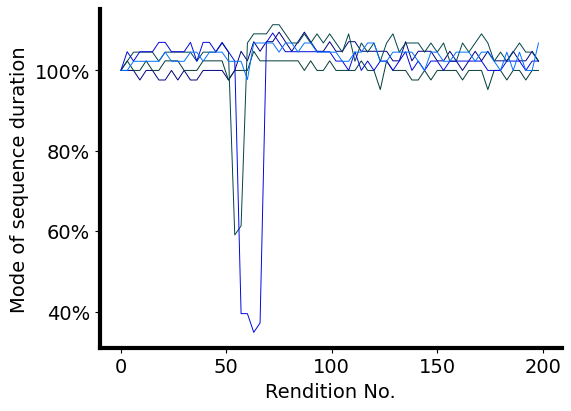

In [45]:
make_duration_mode_graphs(['gradual_dropout'],
                           timepoints=np.arange(0, 200), n_exc=200, new_cell_idx=200)

In [53]:
def make_timing_precision_graphs(names, timepoints=[600], n_exc=200, new_cell_idx=200, period=50):
    all_dirs = []
    for name in names:
        if type(names) is list:
            all_dirs.append([dirs for dirs in filter_list_by_name_frags(all_in_dir('./robustness'), name)])
        else:
            all_dirs.append([dirs for dirs in filter_list_by_name_frags(all_in_dir('./robustness'), [name])])
    
    for i, exp_dir_names in enumerate(all_dirs):   
        scale = 1.1
        fig = plt.figure(constrained_layout=True, figsize=(5 * scale, 5 * scale))
        gs = gridspec.GridSpec(ncols=1, nrows=2, figure=fig)
        axs = [fig.add_subplot(gs[0]), fig.add_subplot(gs[1])]
        
        all_avg_timing_entropies = []
        all_avg_percents_active = []
        
        for j, exp_dir_name in enumerate(exp_dir_names):
            if exp_dir_name not in recovered_exp_names:
                continue
            print(exp_dir_name)
            
            avg_percents_active = []
            avg_timing_entropy = []
            
            spikes_for_period = [[] for l in range(n_exc)]
            cells_active_for_period = []

            for tp, data in load_exp_data(os.path.join('./robustness', exp_dir_name), timepoints, n_exc=n_exc):
                if tp == timepoints[-1] or (tp % period == 0 and tp != timepoints[0]):
                    entropies_for_period = []
                    for l in range(n_exc):
                        if len(spikes_for_period[l]) > 0:
                            bins, vals = bin_occurrences(np.array(spikes_for_period[l]), min_val=0, max_val=0.14, bin_size=0.01)
                            entropies_for_period.append(stats.entropy(vals / np.sum(vals)))
                            
                    cells_active_for_period = np.array(cells_active_for_period)
                    percents_active = np.mean(cells_active_for_period, axis=0)
                    
                    avg_timing_entropy.append(np.nanmean(entropies_for_period))
                    avg_percents_active.append(np.nanmean(percents_active[percents_active > 0.001]))
                    
                    entropies_for_period = []
                    cells_active_for_period = []
                
                cells_active_for_rendition = np.zeros((n_exc))
                
                exc_raster_unperturbed = data['exc_raster_unperturbed']
                for k, cell_idx in enumerate(exc_raster_unperturbed[1, :]):
                    spikes_for_period[int(cell_idx)].append(exc_raster_unperturbed[0, k])
                    cells_active_for_rendition[int(cell_idx)] = 1
                    
                cells_active_for_period.append(cells_active_for_rendition)
            
            all_avg_percents_active.append(avg_percents_active)
            all_avg_timing_entropies.append(avg_timing_entropy)
            
        all_avg_percents_active = np.array(all_avg_percents_active)
        all_avg_timing_entropies = np.array(all_avg_timing_entropies)

        axs[0].plot(timepoints[np.arange(0, len(timepoints), period)], np.nanmean(all_avg_percents_active, axis=0), lw=1, c='red', zorder=0, alpha=1)
        axs[0].locator_params(axis='x', nbins=5)
        axs[1].plot(timepoints[np.arange(0, len(timepoints), period)], np.nanmean(all_avg_timing_entropies, axis=0), lw=1, c='red', zorder=0, alpha=1)
        axs[1].locator_params(axis='x', nbins=5)
        
        for axs_idx in range(2):
            set_font_size(axs[axs_idx], 16)
            axs[axs_idx].spines['right'].set_visible(False)
            axs[axs_idx].spines['top'].set_visible(False)
            axs[axs_idx].set_xlabel('Rendition No.')
        
        axs[0].set_ylabel('Mean individual neuron\nrate of participation')
        axs[1].set_ylabel('Mean entropy in single\nneuron spike timing')
#         axs[0].set_ylim(0, 0.0025)
#         axs[0].set_xlim(0.05)

In [ ]:
def make_timing_error_graphs(names, timepoints_1, timepoints_2, n_exc=300, new_cell_idx=200):
    all_dirs = []
    for name in names:
        if type(names) is list:
            all_dirs.append([dirs for dirs in filter_list_by_name_frags(all_in_dir('./robustness'), name)])
        else:
            all_dirs.append([dirs for dirs in filter_list_by_name_frags(all_in_dir('./robustness'), [name])])
    
    for i, exp_dir_names in enumerate(all_dirs):   
        scale = 1.1
        fig = plt.figure(constrained_layout=True, figsize=(5 * scale, 5 * scale))
        gs = gridspec.GridSpec(ncols=1, nrows=2, figure=fig)
        axs = [fig.add_subplot(gs[:, 0])]
        
        for j, exp_dir_name in enumerate(exp_dir_names):
            if exp_dir_name not in recovered_exp_names:
                continue
            print(exp_dir_name)
            
            j = 0
            all_first_spk_times = []

            for i, load_data in load_exp_data(os.path.join('./robustness', exp_dir_name), n_exc=n_exc):
                if j < len(timepoints) and i == timepoints[j]:
                    data = load_data()
                    first_spk_times = data['first_spk_times']
                    original_surviving_mask = np.arange(n_exc) < new_cell_idx     
                    if 'surviving_cell_mask' in data:
                        original_surviving_mask = np.logical_and(original_surviving_mask, data['surviving_cell_mask']).astype(bool)
                    first_spk_times = data['first_spk_times'][original_surviving_mask]
                    all_first_spk_times.append(first_spk_times)
                    j += 1
            
            all_first_spk_times = np.stack(all_first_spk_times)
            all_nan_means = np.nanmean(all_first_spk_times, axis=0)
            all_nan_stds = np.nanstd(all_first_spk_times, axis=0)

            axs[0].scatter(all_nan_means, all_nan_stds, s=2, c='black', zorder=0, alpha=1)

        set_font_size(axs[0], 16)
        axs[0].spines['right'].set_visible(False)
        axs[0].spines['top'].set_visible(False)

        axs[0].set_xlabel('Firing time (s)')
        axs[0].set_ylabel('First spike STD (s)')

        axs[0].set_ylim(0, 0.0025)
        axs[0].set_xlim(0.05)

In [218]:
def make_figure_3c(name, ylim=(0, 8), initial_timepoint_range=(90, 99), final_timepoint_range=(249, 259), n_exc=200, color='blue', xlim1=(0, 10), xlim2=(0, 10), ylim1=(0, 10), ylim2=(0, 10)):    
    all_dirs = [dirs for dirs in filter_list_by_name_frags(all_in_dir('./robustness'), name)]
            
    labels = [
        'unperturbed',
        '1500th rendition',
    ]
    
    scale = 1.9
    fig = plt.figure(constrained_layout=True, figsize=(5 * scale, 5 * scale))
    gs = gridspec.GridSpec(ncols=4, nrows=2, figure=fig)
    
    def create_split_freq_plot(row_start, row_end, col_start, fig, gs):
        sub_axs = [
            fig.add_subplot(gs[row_start:row_end, col_start:(col_start+3)])
        ]
#         sub_axs[0].yaxis.tick_right()
        sub_axs[0].set_xlim(0, 45)
        sub_axs[0].set_ylim(0, 1000)
#         sub_axs[0].spines['left'].set_visible(False)
        sub_axs[0].spines['top'].set_visible(False)
        return sub_axs
    
    axs = [
        create_split_freq_plot(0, 1, 0, fig, gs),
        create_split_freq_plot(1, 2, 0, fig, gs),
    ]
    
    
    firing_rate_stats_initial = {
        'spk_bins_e': None,
        'freqs_e': [],
        'spk_bins_i': None,
        'freqs_i': [],
    }
    firing_rate_stats_final = copy(firing_rate_stats_initial)
           
    for idx, exp_dir_name in enumerate(all_dirs):
        for i, data_load in load_exp_data(os.path.join('./robustness', exp_dir_name), n_exc=n_exc):
            if (i >= initial_timepoint_range[0] and i <= initial_timepoint_range[1]) or (i >= final_timepoint_range[0] and i <= final_timepoint_range[1]):
                    data = data_load()

                    spk_bins_e = data['spk_bins']
                    freqs_e = data['freqs']
                    spks_for_i_cells = data['inh_raster']
                    
                    if len(spks_for_i_cells) > 0:
                        spks_for_i_cells = spks_for_i_cells[1]
                        cell_labels, spks_i = bin_occurrences(spks_for_i_cells, min_val=n_exc, max_val=n_exc + 30, bin_size=1)
                        spk_bins_i, freqs_i = bin_occurrences(spks_i, max_val=100, bin_size=1)
                    else:
                        spk_bins_i, freqs_i = (np.zeros(100), np.zeros(100))
                        
                    if (i >= initial_timepoint_range[0] and i <= initial_timepoint_range[1]):
                        firing_rate_stats = firing_rate_stats_initial
                    else:
                        firing_rate_stats = firing_rate_stats_final
                        
                    if firing_rate_stats['spk_bins_e'] is None:
                        firing_rate_stats['spk_bins_e'] = spk_bins_e
                    if firing_rate_stats['spk_bins_i'] is None:
                        firing_rate_stats['spk_bins_i'] = spk_bins_i
                    firing_rate_stats['freqs_e'].append(freqs_e)
                    firing_rate_stats['freqs_i'].append(freqs_i)
        
    for firing_rate_stats in [firing_rate_stats_initial, firing_rate_stats_final]:
        firing_rate_stats['freqs_e_zero'] = (np.mean(np.stack(firing_rate_stats['freqs_e']), axis=0)[0], np.std(np.stack(firing_rate_stats['freqs_e']), axis=0)[0])
        firing_rate_stats['freqs_i_zero'] = (np.mean(np.stack(firing_rate_stats['freqs_i']), axis=0)[0], np.std(np.stack(firing_rate_stats['freqs_i']), axis=0)[0])
        firing_rate_stats['freqs_e'] = (np.mean(np.stack(firing_rate_stats['freqs_e']), axis=0), np.std(np.stack(firing_rate_stats['freqs_e']), axis=0))
        firing_rate_stats['freqs_i'] = (np.mean(np.stack(firing_rate_stats['freqs_i']), axis=0), np.std(np.stack(firing_rate_stats['freqs_i']), axis=0))

    freqs_e_initial_low = firing_rate_stats_initial['freqs_e'][0] - firing_rate_stats_initial['freqs_e'][1]
    freqs_e_initial_high = firing_rate_stats_initial['freqs_e'][0] + firing_rate_stats_initial['freqs_e'][1]
    axs[0][0].fill_between(firing_rate_stats_initial['spk_bins_e'], y1=freqs_e_initial_low, y2=freqs_e_initial_high, color='black', alpha=0.15, zorder=-1)
    axs[0][0].plot(firing_rate_stats_initial['spk_bins_e'], firing_rate_stats_initial['freqs_e'][0], color='black', alpha=1., zorder=-1, lw=1.2, label=labels[0])
#     axs[0][0].errorbar(firing_rate_stats_initial['spk_bins_e'], firing_rate_stats_initial['freqs_e'][0], yerr=firing_rate_stats_initial['freqs_e'][1], color='black', alpha=1., zorder=-1)
#     axs[0][0].scatter(firing_rate_stats_initial['spk_bins_e'], firing_rate_stats_initial['freqs_e'][0], color='black', alpha=1., zorder=-1, s=20, label=labels[0]) 
    
    freqs_i_initial_low = firing_rate_stats_initial['freqs_i'][0] - firing_rate_stats_initial['freqs_i'][1]
    freqs_i_initial_high = firing_rate_stats_initial['freqs_i'][0] + firing_rate_stats_initial['freqs_i'][1]
    axs[1][0].fill_between(firing_rate_stats_initial['spk_bins_i'], y1=freqs_i_initial_low, y2=freqs_i_initial_high, color='blue', alpha=0.15, zorder=-1)
    axs[1][0].plot(firing_rate_stats_initial['spk_bins_i'], firing_rate_stats_initial['freqs_i'][0], '--', color='blue', alpha=0.6, zorder=-1, lw=1.2, label=labels[0] + ' inh')

    freqs_e_final_low = firing_rate_stats_final['freqs_e'][0] - firing_rate_stats_final['freqs_e'][1]
    freqs_e_final_high = firing_rate_stats_final['freqs_e'][0] + firing_rate_stats_final['freqs_e'][1]
    axs[0][0].fill_between(firing_rate_stats_final['spk_bins_e'], y1=freqs_e_final_low, y2=freqs_e_final_high, color='purple', alpha=0.15, zorder=-1)
    axs[0][0].plot(firing_rate_stats_final['spk_bins_e'], firing_rate_stats_final['freqs_e'][0], color='purple', alpha=1., zorder=0, lw=1.2, label=labels[1])
#     axs[0][0].errorbar(firing_rate_stats_final['spk_bins_e'], firing_rate_stats_final['freqs_e'][0], yerr=firing_rate_stats_final['freqs_e'][1], color='purple', alpha=1., zorder=-1)
#     axs[0][0].scatter(firing_rate_stats_final['spk_bins_e'], firing_rate_stats_final['freqs_e'][0], color='purple', alpha=1., zorder=-1, s=20, label=labels[0]) 
    
    freqs_i_final_low = firing_rate_stats_final['freqs_i'][0] - firing_rate_stats_final['freqs_i'][1]
    freqs_i_final_high = firing_rate_stats_final['freqs_i'][0] + firing_rate_stats_final['freqs_i'][1]
    axs[1][0].fill_between(firing_rate_stats_final['spk_bins_i'], y1=freqs_i_final_low, y2=freqs_i_final_high, color='blue', alpha=0.15, zorder=-1)
    axs[1][0].plot(firing_rate_stats_final['spk_bins_i'], firing_rate_stats_final['freqs_i'][0], color='blue', alpha=1., zorder=0, lw=1.2, label=labels[1] + ' inh')

#     axs[0][0].errorbar(-.5, firing_rate_stats_initial['freqs_e_zero'][0], yerr=firing_rate_stats_initial['freqs_e_zero'][1], color='black', alpha=1., zorder=-1)
#     axs[0][0].bar(-.5, firing_rate_stats_initial['freqs_e_zero'][0], color='black', alpha=0.7, zorder=-1, width=0.75)
#     axs[0][0].errorbar(.5, firing_rate_stats_final['freqs_e_zero'][0], yerr=firing_rate_stats_final['freqs_e_zero'][1], color='purple', alpha=1., zorder=-1)
#     axs[0][0].bar(.5, firing_rate_stats_final['freqs_e_zero'][0], color='purple', alpha=0.7, zorder=-1, width=0.75)    

#     axs[1][0].errorbar(-.5, firing_rate_stats_initial['freqs_i_zero'][0], yerr=firing_rate_stats_initial['freqs_i_zero'][1], color='blue', alpha=1., zorder=-1)
#     axs[1][0].bar(-.5, firing_rate_stats_initial['freqs_i_zero'][0], color='blue', alpha=0.4, zorder=-1, width=0.75)
#     axs[1][0].errorbar(.5, firing_rate_stats_final['freqs_i_zero'][0], yerr=firing_rate_stats_final['freqs_i_zero'][1], color='blue', alpha=1., zorder=-1)
#     axs[1][0].bar(.5, firing_rate_stats_final['freqs_i_zero'][0], color='blue', alpha=0.7, zorder=-1, width=0.75)
    
    axs[0][0].set_ylabel('Excitatory counts')
    axs[1][0].set_ylabel('Inhibitory counts')
    axs[0][0].set_xlabel('Spikes per rendition')
    axs[1][0].set_xlabel('Spikes per rendition')
    axs[0][0].set_xlim(xlim1)
    axs[1][0].set_xlim(xlim2)
#     axs[0].spines['top'].set_visible(False)
#     axs[1].spines['top'].set_visible(False)
    axs[0][0].set_ylim(ylim1)
    axs[1][0].set_ylim(ylim2)
#     axs[1].set_ylim(0, 16)

#     axs[0].legend(frameon=False)
    
    for i in range(1):
        set_font_size(axs[0][i], 15)
        set_font_size(axs[1][i], 15)

    plt.locator_params(axis='x', nbins=5)
    
    save_fig(fig, './figures/paper/firing_rates', f'{" ".join(name)}.svg')

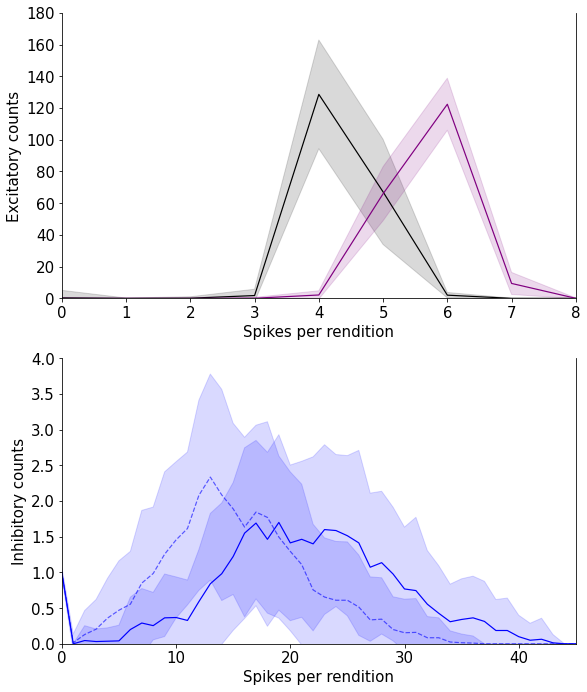

In [219]:
make_figure_3c(
    ['low_growth', 'DROP_SEV_0.5', 'CONDITION_no_repl_PER_SILENT_0_2022'],
    initial_timepoint_range=(90, 99), final_timepoint_range=(249, 259),
    xlim1=(0, 8), ylim1=(0, 180), xlim2=(0, 45), ylim2=(0, 4))

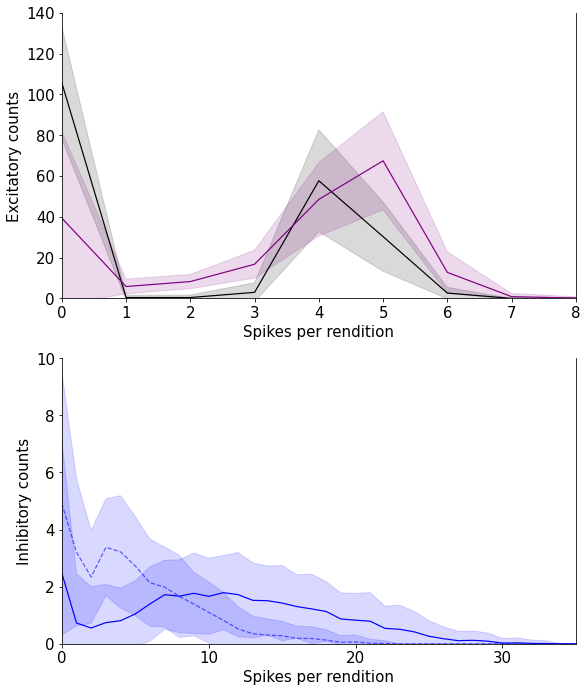

In [220]:
make_figure_3c(
    ['DROP_SEV_0.5', 'CONDITION_no_repl_no_syn_PER_SILENT_0.5_2022'],
    initial_timepoint_range=(90, 99), final_timepoint_range=(249, 259),
    xlim1=(0, 8), ylim1=(0, 140), xlim2=(0, 35), ylim2=(0, 10))

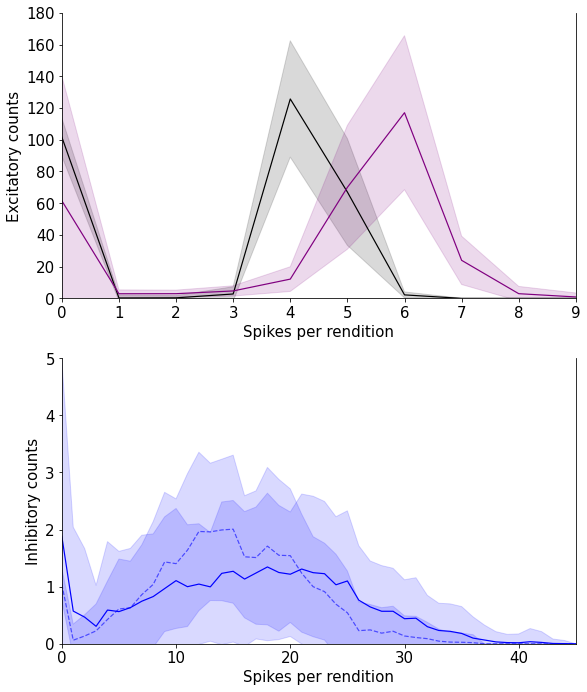

In [221]:
make_figure_3c(
    ['DROP_SEV_0.5', 'CONDITION_all_PER_SILENT_0_2022'],
    initial_timepoint_range=(90, 99), final_timepoint_range=(249, 259), n_exc=300,
    xlim1=(0, 9), ylim1=(0, 180), xlim2=(0, 45), ylim2=(0, 5))